# Functions

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit
import matplotlib.pyplot as plt
import random
import pandas as pd
import random
import datetime, os
import io
import seaborn as sns
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.initializers import glorot_normal,  he_normal
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import ConvLSTM1D, Flatten, Input, Dense, Lambda, LSTM, RepeatVector, Bidirectional, Masking, Dropout, Layer, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, ConvLSTM3D, Conv1D, ConvLSTM2D, MaxPool1D, AvgPool1D, Conv2D, AvgPool2D
from google.colab import drive
import numpy as np
from tensorflow.python.framework.ops import disable_eager_execution
from tensorflow.keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras
import os
from sklearn.decomposition import PCA
import time
import pickle
import numpy as np

from sklearn.mixture import GaussianMixture
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from utils import plot_rul_one_engine
from utils import get_predictions_ensemble
from utils import get_predictions_ensemble1
from utils import plot_sorted
from utils import rul_col_series
from utils import add_operating_condition
from utils import add_health_index
from utils import condition_scaler
from utils import exponential_smoothing
from utils import gen_train_data
from utils import gen_labels
from utils import gen_test_data
from utils import gen_data_wrapper
from utils import gen_label_wrapper
from utils import process_data_standard

In [ ]:
from utils import process_data_standard2

# Models

## Model Encoder

In [ ]:
dataset = 'FD001'
# files
dir_path = '/content/drive/MyDrive/CMAPSSData/'



# data readout
sensor_names  = ["tfan_in_tot", "tLPC_out_tot", "tHPC_out_tot",
           "tLPT_out_tot", "pfan_in", "pbypass_tot", "pHPC_out_tot", "fan_speed_physical", "core_speed_physical",
           "P50_P2_ratio", "pHPC_out_stat", "fuel_flow_to_Ps30", "fan_speed_corrected", "core_speed_corrected",
           "bypass_ratio", "burnerfuel_air_ratio", "bleed_enthalpy", "fan_speed_demanded", "fan_speed_demanded_corrected" ,
           "HPT_coolant_bleed", "LPT_coolant_bleed"]


sensors = ['tLPC_out_tot', 'tHPC_out_tot', 'tLPT_out_tot', 'pbypass_tot',
       'pHPC_out_tot', 'fan_speed_physical', 'core_speed_physical',
       'pHPC_out_stat', 'fuel_flow_to_Ps30', 'fan_speed_corrected',
       'core_speed_corrected', 'bypass_ratio', 'bleed_enthalpy',
       'HPT_coolant_bleed', 'LPT_coolant_bleed']




### Define model 1

In [ ]:
#disable_eager_execution()


x_train, y_train, x_val, y_val, x_test, y_test, X_train_pre, X_test_pre = process_data_standard2(dataset,
                                                                                                sensors,
                                                                                                dir_path,
                                                                                                condition = 'all',

                                                                                                algo='regr',

                                                                                                )

tf.keras.utils.set_random_seed(237)






In [ ]:
from re import X
# Setup the network parameters:
timesteps =x_train.shape[1]
input_dim = x_train.shape[2]
intermediate_dim = 300
batch_size = 128
latent_dim = 2
epochs = 10
# used to mask values in sequences with less than 30 cycles until 30 is reached
masking_value = -99.

class Sampling(keras.layers.Layer):
  """Uses (z_mean, sigma) to sample z, the vector encoding an engine trajetory."""
  def call(self, inputs):
    mu, sigma = inputs
    batch = tf.shape(mu)[0]
    dim = tf.shape(mu)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return mu + tf.exp(0.5 * sigma) * epsilon



In [ ]:
# ----------------------- Encoder -----------------------
inputs = Input(shape=(timesteps, input_dim,), name='encoder_input')

mask = Masking(mask_value=masking_value)(inputs)

# LSTM encoding
h = Bidirectional(LSTM(intermediate_dim))(mask)

# VAE Z layer
mu = Dense(latent_dim)(h)
sigma = Dense(latent_dim)(h)

z = Sampling()([mu, sigma])

# Instantiate the encoder model:
encoder = keras.Model(inputs, [mu, sigma, z], name='encoder')
print(encoder.summary())
# -------------------------------------------------------

# ----------------------- Regressor --------------------
reg_latent_inputs = Input(shape=(latent_dim,), name='z_sampling_reg')
reg_intermediate = Dense(200, activation='tanh')(reg_latent_inputs)
reg_outputs = Dense(1, name='reg_output')(reg_intermediate)
# Instantiate the classifier model:
regressor = keras.Model(reg_latent_inputs, reg_outputs, name='regressor')
print(regressor.summary())
# -------------------------------------------------------


# ----------------------- Decoder --------------------
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
h_decoded = RepeatVector(timesteps)(latent_inputs)
h_decoded = Bidirectional(LSTM(intermediate_dim, return_sequences=True))(h_decoded)
# decoded layer
outputs = LSTM(input_dim, return_sequences=True)(h_decoded)

# Instantiate the decoder model:
decoder = keras.Model(latent_inputs, outputs, name='decoder')
print(decoder.summary())
# -------------------------------------------------------

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 30, 15)]             0         []                            
                                                                                                  
 masking (Masking)           (None, 30, 15)               0         ['encoder_input[0][0]']       
                                                                                                  
 bidirectional (Bidirection  (None, 600)                  758400    ['masking[0][0]']             
 al)                                                                                              
                                                                                                  
 dense (Dense)               (None, 2)                    1202      ['bidirectional[0][0]'] 

In [ ]:
class RVE(keras.Model):
    def __init__(self, encoder, regressor, decoder=None, **kwargs):
        super(RVE, self).__init__(**kwargs)
        self.encoder = encoder
        self.regressor = regressor
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.reg_loss_tracker = keras.metrics.Mean(name="reg_loss")
        self.decoder = decoder
        if self.decoder!=None:
          self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")


    @property
    def metrics(self):
      if self.decoder!=None:
        return [
            self.total_loss_tracker,
            self.kl_loss_tracker,
            self.reg_loss_tracker,
            self.reconstruction_loss_tracker
        ]
      else:
        return [
            self.total_loss_tracker,
            self.kl_loss_tracker,
            self.reg_loss_tracker,
        ]

    def train_step(self, data):
        x, target_x = data
        with tf.GradientTape() as tape:
            # kl loss
            mu, sigma, z = self.encoder(x)
            kl_loss = -0.5 * (1 + sigma - tf.square(mu) - tf.exp(sigma))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            # Regressor
            reg_prediction = self.regressor(z)
            reg_loss = tf.reduce_mean(
                keras.losses.mse(target_x, reg_prediction)
            )
            # Reconstruction
            if self.decoder!=None:
              reconstruction = self.decoder(z)
              reconstruction_loss = tf.reduce_mean(
                  keras.losses.mse(x, reconstruction)
              )
              total_loss = kl_loss + reg_loss + reconstruction_loss
              self.reconstruction_loss_tracker.update_state(reconstruction_loss)
            else:
              total_loss = kl_loss + reg_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.reg_loss_tracker.update_state(reg_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "reg_loss": self.reg_loss_tracker.result(),
        }


    def test_step(self, data):
        x, target_x = data

        # kl loss
        mu, sigma, z = self.encoder(x)
        kl_loss = -0.5 * (1 + sigma - tf.square(mu) - tf.exp(sigma))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        # Regressor
        reg_prediction = self.regressor(z)
        reg_loss = tf.reduce_mean(
            keras.losses.mse(target_x, reg_prediction)
        )
        # Reconstruction
        if self.decoder!=None:
          reconstruction = self.decoder(z)
          reconstruction_loss = tf.reduce_mean(
              keras.losses.mse(x, reconstruction)
          )

          total_loss = kl_loss + reg_loss + reconstruction_loss
        else:
          total_loss = kl_loss + reg_loss

        return {
            "loss": total_loss,
            "kl_loss": kl_loss,
            "reg_loss": reg_loss,
        }

### Train model 1

In [ ]:
# original using 15 feat
#https://github.com/NahuelCostaCortez/Remaining-Useful-Life-Estimation-Variational/blob/main/RULRVE.ipynb
#keras.backend.clear_session()

from re import X

rve = RVE(encoder, regressor)
rve.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))
settings = {'epochs':100, 'batch_size':128, 'input_dim': input_dim, 'intermediate_dim':300, 'latent_dim':2, 'opt':'Adam', 'lr':0.001}

start_time = time.time()
history = rve.fit(x_train, y_train, epochs=settings['epochs'], validation_data=(x_val, y_val), batch_size=batch_size)
end_time = time.time()

training_time = end_time - start_time
settings['training_time'] = training_time

filehandler = open(b"/content/drive/MyDrive/pickled_history_new/history_encoder_base_.pkl","ab")
pickle.dump((history.history, settings),filehandler)

In [ ]:
preds =  encoder.predict(x_test, batch_size=128)
preds1  = rve.regressor.predict(preds[0])

4/4 [==============================] - 0s 3ms/step


17.677508566476146
16.826620651274865


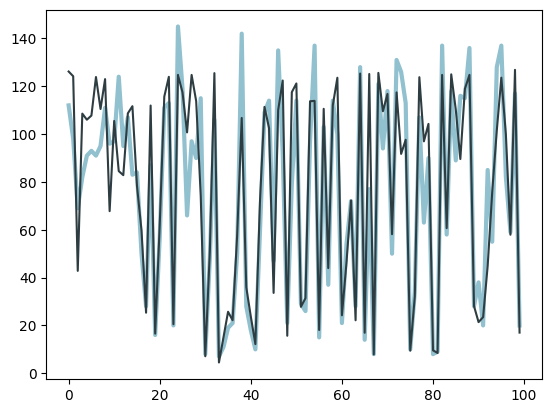

In [ ]:
plt.plot(y_test, label='true RUL', c='#91c0cf', linewidth=3.0)
plt.plot(preds1.mean(axis=1).flatten(), label='prediction', c = '#2e3d42',)


sum_sq = sum((preds1.flatten() - y_test.values.flatten())**2)
sum_sq =(sum_sq/100)**(1/2)

print(sum_sq)

y_test_c = y_test.copy()
y_test_c['RemainingUsefulLife'].clip(upper=125, inplace=True)
sum_sq1 = sum((preds1.flatten() - y_test_c.values.flatten())**2)
sum_sq1 =(sum_sq1/100)**(1/2)
print(sum_sq1)


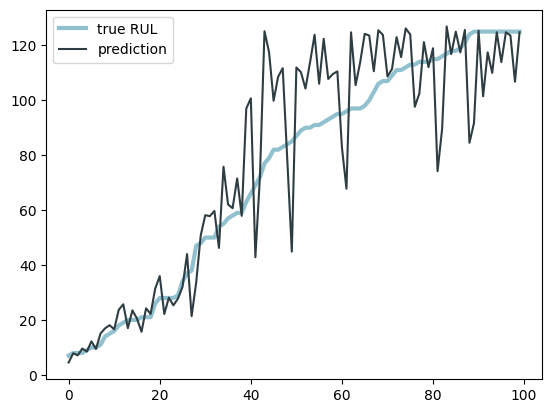

In [ ]:
plot_sorted(preds1, y_test, 'encoder1')

In [ ]:
filehandler = open(b"/content/drive/MyDrive/pickled_predictions_new/preds_encoder_base.pkl","ab")
pickle.dump((preds1, sum_sq1, sum_sq),filehandler)

### Train model 2

In [ ]:
# original using 15 feat
#https://github.com/NahuelCostaCortez/Remaining-Useful-Life-Estimation-Variational/blob/main/RULRVE.ipynb
#keras.backend.clear_session()

from re import X

rve = RVE(encoder, regressor)
rve.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))
settings = {'epochs':100, 'batch_size':128, 'input_dim': input_dim, 'intermediate_dim':600, 'latent_dim':2, 'opt':'Adam', 'lr':0.001}

start_time = time.time()
history = rve.fit(x_train, y_train, epochs=settings['epochs'], validation_data=(x_val, y_val), batch_size=batch_size)
end_time = time.time()

training_time = end_time - start_time
settings['training_time'] = training_time

filehandler = open(b"/content/drive/MyDrive/pickled_history_new/history_encoder_var1.pkl","ab")
pickle.dump((history.history, settings),filehandler)

In [ ]:
preds =  encoder.predict(x_test, batch_size=128)
preds1  = rve.regressor.predict(preds[0])

4/4 [==============================] - 0s 4ms/step


18.190829221474704
17.35676200388445


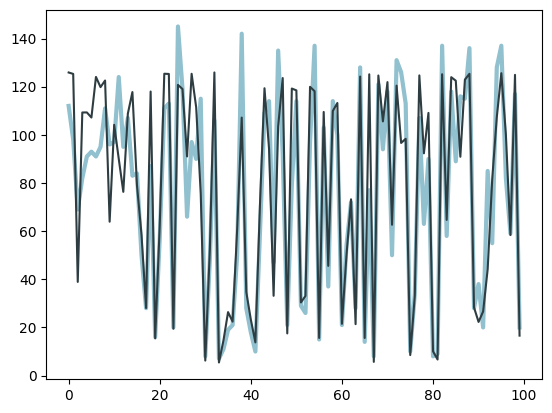

In [ ]:
plt.plot(y_test, label='true RUL', c='#91c0cf', linewidth=3.0)
plt.plot(preds1.mean(axis=1).flatten(), label='prediction', c = '#2e3d42',)


sum_sq = sum((preds1.flatten() - y_test.values.flatten())**2)
print((sum_sq/100)**(1/2))

y_test_c = y_test.copy()
y_test_c['RemainingUsefulLife'].clip(upper=125, inplace=True)
sum_sq = sum((preds1.flatten() - y_test_c.values.flatten())**2)
print((sum_sq/100)**(1/2))


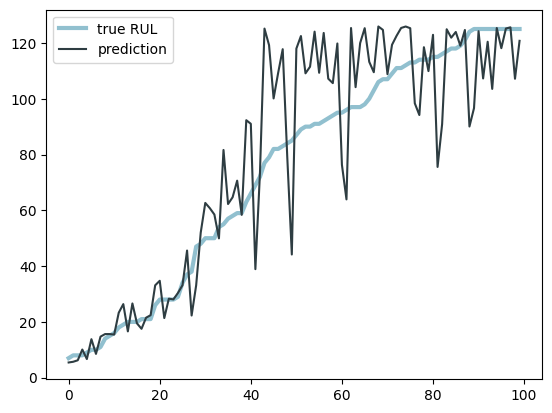

In [ ]:
plot_sorted(preds1, y_test, 'encoder1_var1')

In [ ]:
filehandler = open(b"/content/drive/MyDrive/pickled_predictions_new/preds_encoder_var1.pkl","ab")
pickle.dump((preds1, sum_sq1, sum_sq),filehandler)



### Train model 3

In [ ]:
# original using 15 feat
#https://github.com/NahuelCostaCortez/Remaining-Useful-Life-Estimation-Variational/blob/main/RULRVE.ipynb
#keras.backend.clear_session()

from re import X

rve = RVE(encoder, regressor)
rve.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))
settings = {'epochs':100, 'batch_size':256, 'input_dim': input_dim, 'intermediate_dim':300, 'latent_dim':2, 'opt':'Adam', 'lr':0.001}

start_time = time.time()
history = rve.fit(x_train, y_train, epochs=settings['epochs'], validation_data=(x_val, y_val), batch_size=batch_size)
end_time = time.time()

training_time = end_time - start_time
settings['training_time'] = training_time

filehandler = open(b"/content/drive/MyDrive/pickled_history_new/history_encoder_var2.pkl","ab")
pickle.dump((history.history, settings),filehandler)

Epoch 1/100
112/112 [==============================] - 20s 77ms/step - loss: 9.0581 - kl_loss: 3.9498 - reg_loss: 2.4534 - val_loss: 90.9267 - val_kl_loss: 4.4919 - val_reg_loss: 86.4349
Epoch 2/100
112/112 [==============================] - 3s 30ms/step - loss: 4.8528 - kl_loss: 3.9334 - reg_loss: 0.9401 - val_loss: 84.1303 - val_kl_loss: 4.5163 - val_reg_loss: 79.6140
Epoch 3/100
112/112 [==============================] - 2s 20ms/step - loss: 4.9964 - kl_loss: 3.9447 - reg_loss: 1.0771 - val_loss: 100.8257 - val_kl_loss: 4.5309 - val_reg_loss: 96.2947
Epoch 4/100
112/112 [==============================] - 3s 23ms/step - loss: 5.2380 - kl_loss: 3.9481 - reg_loss: 1.2327 - val_loss: 96.4301 - val_kl_loss: 4.5674 - val_reg_loss: 91.8627
Epoch 5/100
112/112 [==============================] - 5s 40ms/step - loss: 5.1492 - kl_loss: 3.9543 - reg_loss: 1.2446 - val_loss: 89.6879 - val_kl_loss: 4.6021 - val_reg_loss: 85.0858
Epoch 6/100
112/112 [==============================] - 4s 32ms/step 

In [ ]:
preds =  encoder.predict(x_test, batch_size=128)
preds1  = rve.regressor.predict(preds[0])

4/4 [==============================] - 0s 6ms/step


18.537088150005218
17.76765705698663


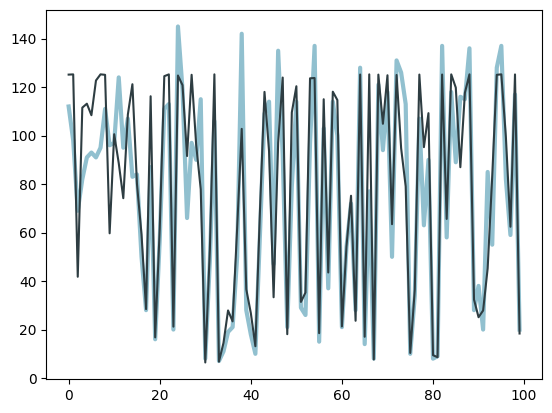

In [ ]:
plt.plot(y_test, label='true RUL', c='#91c0cf', linewidth=3.0)
plt.plot(preds1.mean(axis=1).flatten(), label='prediction', c = '#2e3d42',)


sum_sq = sum((preds1.flatten() - y_test.values.flatten())**2)
print((sum_sq/100)**(1/2))

y_test_c = y_test.copy()
y_test_c['RemainingUsefulLife'].clip(upper=125, inplace=True)
sum_sq = sum((preds1.flatten() - y_test_c.values.flatten())**2)
print((sum_sq/100)**(1/2))


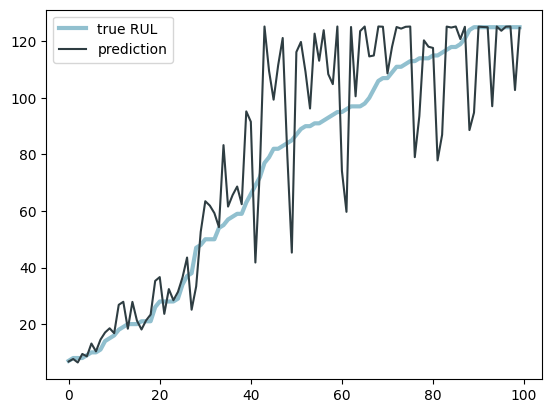

In [ ]:
plot_sorted(preds1, y_test, 'encoder_var2')

In [ ]:
filehandler = open(b"/content/drive/MyDrive/pickled_predictions_new/preds_encoder_var2.pkl","ab")
pickle.dump((preds1, sum_sq1, sum_sq),filehandler)



### Train model 4

In [ ]:
# original using 15 feat
#https://github.com/NahuelCostaCortez/Remaining-Useful-Life-Estimation-Variational/blob/main/RULRVE.ipynb
#keras.backend.clear_session()

from re import X

rve = RVE(encoder, regressor)
rve.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))
settings = {'epochs':100, 'batch_size':256, 'input_dim': input_dim, 'intermediate_dim':600, 'latent_dim':2, 'opt':'Adam', 'lr':0.001}

start_time = time.time()
history = rve.fit(x_train, y_train, epochs=settings['epochs'], validation_data=(x_val, y_val), batch_size=batch_size)
end_time = time.time()

training_time = end_time - start_time
settings['training_time'] = training_time

filehandler = open(b"/content/drive/MyDrive/pickled_history_new/history_encoder_var3.pkl","ab")
pickle.dump((history.history, settings),filehandler)

In [ ]:
preds =  encoder.predict(x_test, batch_size=128)
preds1  = rve.regressor.predict(preds[0])

4/4 [==============================] - 0s 2ms/step


18.782128220258556
18.024017426498705


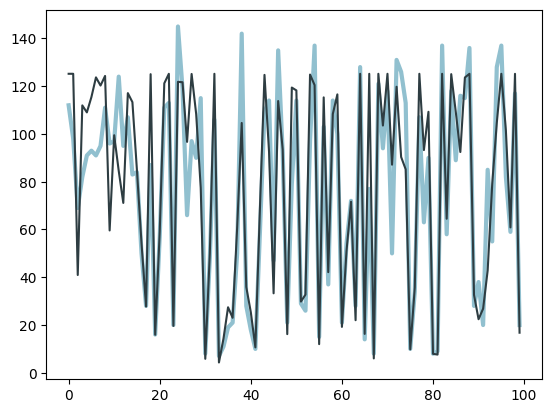

In [ ]:
plt.plot(y_test, label='true RUL', c='#91c0cf', linewidth=3.0)
plt.plot(preds1.mean(axis=1).flatten(), label='prediction', c = '#2e3d42',)


sum_sq = sum((preds1.flatten() - y_test.values.flatten())**2)
print((sum_sq/100)**(1/2))

y_test_c = y_test.copy()
y_test_c['RemainingUsefulLife'].clip(upper=125, inplace=True)
sum_sq = sum((preds1.flatten() - y_test_c.values.flatten())**2)
print((sum_sq/100)**(1/2))


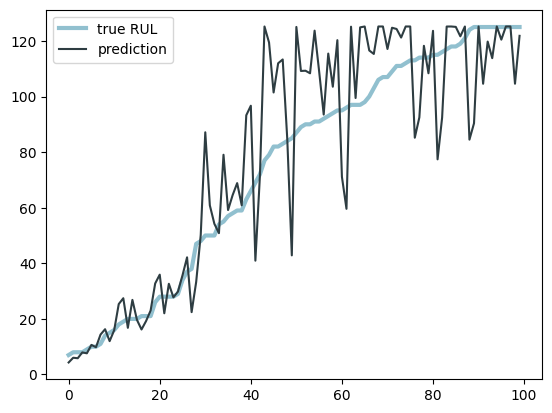

In [ ]:
plot_sorted(preds1, y_test, 'encoder_var3')

In [ ]:
filehandler = open(b"/content/drive/MyDrive/pickled_predictions_new/preds_encoder_var3.pkl","ab")
pickle.dump((preds1, sum_sq1, sum_sq),filehandler)

### Best model encoder

In [ ]:
# original using 15 feat
#https://github.com/NahuelCostaCortez/Remaining-Useful-Life-Estimation-Variational/blob/main/RULRVE.ipynb
#keras.backend.clear_session()

from re import X

rve = RVE(encoder, regressor)
rve.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))
settings = {'epochs':100, 'batch_size':128, 'input_dim': input_dim, 'intermediate_dim':300, 'latent_dim':2, 'opt':'Adam', 'lr':0.001}

start_time = time.time()
history = rve.fit(x_train, y_train, epochs=settings['epochs'], validation_data=(x_val, y_val), batch_size=batch_size)
end_time = time.time()

training_time = end_time - start_time
settings['training_time'] = training_time

filehandler = open(b"/content/drive/MyDrive/pickled_history_new/history_encoder_base1_.pkl","ab")
pickle.dump((history.history, settings),filehandler)

4/4 [==============================] - 0s 2ms/step
17.93560611116802
17.28551774668646


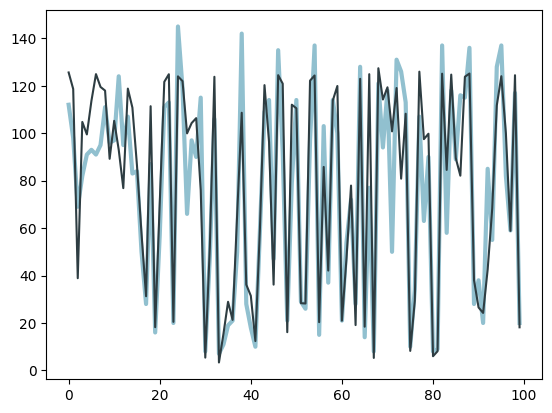

In [ ]:
preds =  encoder.predict(x_test, batch_size=128)
preds1  = rve.regressor.predict(preds[0])

plt.plot(y_test, label='true RUL', c='#91c0cf', linewidth=3.0)
plt.plot(preds1.mean(axis=1).flatten(), label='prediction', c = '#2e3d42',)


sum_sq = sum((preds1.flatten() - y_test.values.flatten())**2)
print((sum_sq/100)**(1/2))

y_test_c = y_test.copy()
y_test_c['RemainingUsefulLife'].clip(upper=125, inplace=True)
sum_sq = sum((preds1.flatten() - y_test_c.values.flatten())**2)
print((sum_sq/100)**(1/2))

In [ ]:
# original using 15 feat
#https://github.com/NahuelCostaCortez/Remaining-Useful-Life-Estimation-Variational/blob/main/RULRVE.ipynb
#keras.backend.clear_session()

from re import X

rve = RVE(encoder, regressor)
rve.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))
settings = {'epochs':100, 'batch_size':128, 'input_dim': input_dim, 'intermediate_dim':300, 'latent_dim':2, 'opt':'Adam', 'lr':0.001}

start_time = time.time()
history = rve.fit(x_train, y_train, epochs=settings['epochs'], validation_data=(x_val, y_val), batch_size=batch_size)
end_time = time.time()

training_time = end_time - start_time
settings['training_time'] = training_time

filehandler = open(b"/content/drive/MyDrive/pickled_history_new/history_encoder_base1_.pkl","ab")
pickle.dump((history.history, settings),filehandler)

4/4 [==============================] - 0s 2ms/step
16.938615214672286
16.277102123989696


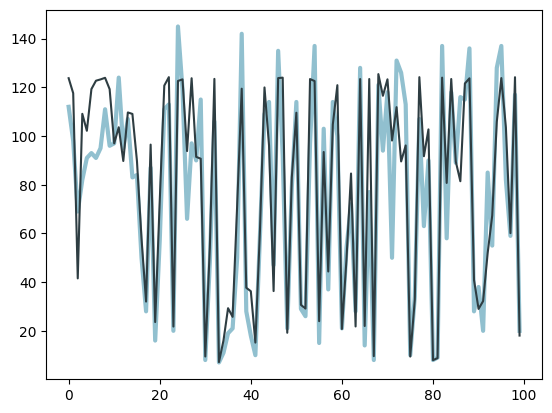

In [ ]:
preds =  encoder.predict(x_test, batch_size=128)
preds1  = rve.regressor.predict(preds[0])

plt.plot(y_test, label='true RUL', c='#91c0cf', linewidth=3.0)
plt.plot(preds1.mean(axis=1).flatten(), label='prediction', c = '#2e3d42',)


sum_sq = sum((preds1.flatten() - y_test.values.flatten())**2)
print((sum_sq/100)**(1/2))

y_test_c = y_test.copy()
y_test_c['RemainingUsefulLife'].clip(upper=125, inplace=True)
sum_sq = sum((preds1.flatten() - y_test_c.values.flatten())**2)
print((sum_sq/100)**(1/2))

In [ ]:
# original using 15 feat
#https://github.com/NahuelCostaCortez/Remaining-Useful-Life-Estimation-Variational/blob/main/RULRVE.ipynb
#keras.backend.clear_session()

from re import X

rve = RVE(encoder, regressor)
rve.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))
settings = {'epochs':100, 'batch_size':128, 'input_dim': input_dim, 'intermediate_dim':300, 'latent_dim':2, 'opt':'Adam', 'lr':0.001}

start_time = time.time()
history = rve.fit(x_train, y_train, epochs=settings['epochs'], validation_data=(x_val, y_val), batch_size=batch_size)
end_time = time.time()

training_time = end_time - start_time
settings['training_time'] = training_time

filehandler = open(b"/content/drive/MyDrive/pickled_history_new/history_encoder_base1_.pkl","ab")
pickle.dump((history.history, settings),filehandler)

4/4 [==============================] - 0s 2ms/step
18.073779738160585
17.439004262726687


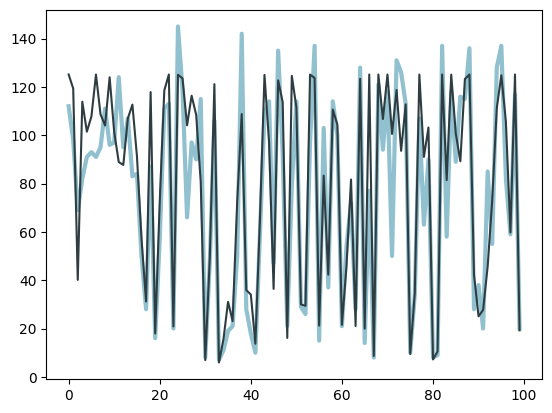

In [ ]:
preds =  encoder.predict(x_test, batch_size=128)
preds1  = rve.regressor.predict(preds[0])

plt.plot(y_test, label='true RUL', c='#91c0cf', linewidth=3.0)
plt.plot(preds1.mean(axis=1).flatten(), label='prediction', c = '#2e3d42',)


sum_sq = sum((preds1.flatten() - y_test.values.flatten())**2)
print((sum_sq/100)**(1/2))

y_test_c = y_test.copy()
y_test_c['RemainingUsefulLife'].clip(upper=125, inplace=True)
sum_sq = sum((preds1.flatten() - y_test_c.values.flatten())**2)
print((sum_sq/100)**(1/2))

In [ ]:
# original using 15 feat
#https://github.com/NahuelCostaCortez/Remaining-Useful-Life-Estimation-Variational/blob/main/RULRVE.ipynb
#keras.backend.clear_session()

from re import X

rve = RVE(encoder, regressor)
rve.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))
settings = {'epochs':100, 'batch_size':128, 'input_dim': input_dim, 'intermediate_dim':300, 'latent_dim':2, 'opt':'Adam', 'lr':0.001}

start_time = time.time()
history = rve.fit(x_train, y_train, epochs=settings['epochs'], validation_data=(x_val, y_val), batch_size=batch_size)
end_time = time.time()

training_time = end_time - start_time
settings['training_time'] = training_time

filehandler = open(b"/content/drive/MyDrive/pickled_history_new/history_encoder_base1_.pkl","ab")
pickle.dump((history.history, settings),filehandler)

4/4 [==============================] - 0s 2ms/step
17.617280694751884
17.01439526628509


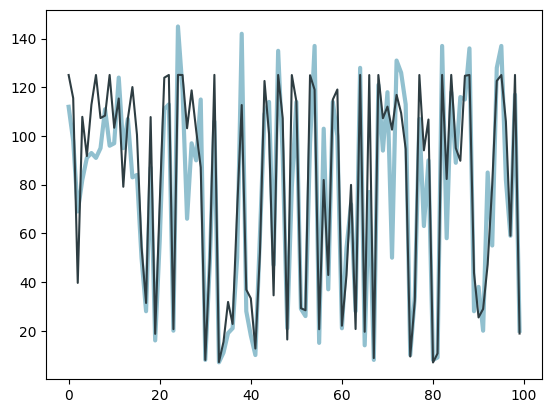

In [ ]:
preds =  encoder.predict(x_test, batch_size=128)
preds1  = rve.regressor.predict(preds[0])

plt.plot(y_test, label='true RUL', c='#91c0cf', linewidth=3.0)
plt.plot(preds1.mean(axis=1).flatten(), label='prediction', c = '#2e3d42',)


sum_sq = sum((preds1.flatten() - y_test.values.flatten())**2)
print((sum_sq/100)**(1/2))

y_test_c = y_test.copy()
y_test_c['RemainingUsefulLife'].clip(upper=125, inplace=True)
sum_sq = sum((preds1.flatten() - y_test_c.values.flatten())**2)
print((sum_sq/100)**(1/2))

## Ensemble

### Base Ensemble

In [ ]:
def custom_loss(sigma):
    def gaussian_loss(y_true, y_pred):
        return tf.reduce_mean(0.5*tf.math.log(sigma) + 0.5*tf.math.divide(tf.math.square(y_true - y_pred), sigma)) + 1e-6
    return gaussian_loss


class GaussianLayer(Layer):
      def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(GaussianLayer, self).__init__(**kwargs)

      def build(self, input_shape):
        self.kernel_1 = self.add_weight(name='kernel_1',
                                      shape=(settings['shape_1'], self.output_dim),
                                      initializer=glorot_normal(),
                                      trainable=True)
        self.kernel_2 = self.add_weight(name='kernel_2',
                                      shape=(settings['shape_1'], self.output_dim),
                                      initializer=glorot_normal(),
                                      trainable=True)
        self.bias_1 = self.add_weight(name='bias_1',
                                    shape=(self.output_dim, ),
                                    initializer=glorot_normal(),
                                    trainable=True)
        self.bias_2 = self.add_weight(name='bias_2',
                                    shape=(self.output_dim, ),
                                    initializer=glorot_normal(),
                                    trainable=True)
        super(GaussianLayer, self).build(input_shape)

      def call(self, x):
        output_mu  = K.dot(x, self.kernel_1) + self.bias_1
        output_sig = K.dot(x, self.kernel_2) + self.bias_2
        output_sig_pos = K.log(1 + K.exp(output_sig)) + 1e-06
        return [output_mu, output_sig_pos]
      def compute_output_shape(self, input_shape):
        return [(input_shape[0], self.output_dim), (input_shape[0], self.output_dim)]


# Train NNs ensembledef create_trained_network(train_x, train_y):




def create_trained_network(X_train, y_train, iter_num):

    callback =tf.keras.callbacks.EarlyStopping(monitor=settings['monitor'], start_from_epoch=35, patience=3)
    checkpoint_path = f"base_training_{iter_num}]/cp.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)

    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                    save_weights_only=True,
                                                    verbose=1, monitor=settings['monitor'] ,save_best_only=True)


    inputs = Input(shape=(settings['window_length'], len(settings['sensors'])))

    x = LSTM(settings['lstm1'],  return_sequences=True)(inputs)
    x = LSTM(settings['lstm2'], )(x)
    x = Dense(settings['shape_1'], activation='relu')(x)
    mu, sigma = GaussianLayer(settings['gaussiann_layer'], name='main_output')(x)
    layer_name = 'main_output' # Where to extract the output from

    model = Model(inputs, mu)

    model.compile(loss=custom_loss(sigma), optimizer='adam', metrics=['mse'])
    print(model.summary())

    history = model.fit(x_train, y_train, epochs=100,
                  validation_data = (x_val, y_val),
                  callbacks = [callback, cp_callback,
                            ],
                  batch_size = settings['batch_size'], verbose = 2)

    pickle.dump( (history.history, settings), open(f"/content/drive/MyDrive/pickled_history_new/{settings['model_name']}_history.pkl", 'ab'))

    print(checkpoint_path)
    model.load_weights(checkpoint_path)
    get_intermediate = K.function(inputs=[model.input], outputs=model.get_layer(layer_name).output)

    return get_intermediate


In [ ]:
dataset = 'FD001'
# files
dir_path = '/content/drive/MyDrive/CMAPSSData/'



# data readout
sensor_names  = ["tfan_in_tot", "tLPC_out_tot", "tHPC_out_tot",
           "tLPT_out_tot", "pfan_in", "pbypass_tot", "pHPC_out_tot", "fan_speed_physical", "core_speed_physical",
           "P50_P2_ratio", "pHPC_out_stat", "fuel_flow_to_Ps30", "fan_speed_corrected", "core_speed_corrected",
           "bypass_ratio", "burnerfuel_air_ratio", "bleed_enthalpy", "fan_speed_demanded", "fan_speed_demanded_corrected" ,
           "HPT_coolant_bleed", "LPT_coolant_bleed"]


sensors = ['tLPC_out_tot', 'tHPC_out_tot', 'tLPT_out_tot', 'pbypass_tot',
       'pHPC_out_tot', 'fan_speed_physical', 'core_speed_physical',
       'pHPC_out_stat', 'fuel_flow_to_Ps30', 'fan_speed_corrected',
       'core_speed_corrected', 'bypass_ratio', 'bleed_enthalpy',
       'HPT_coolant_bleed', 'LPT_coolant_bleed']




In [ ]:
disable_eager_execution()




x_train, y_train, x_val, y_val, x_test, y_test, X_train_pre, X_test_pre = process_data_standard(dataset, sensors, dir_path, 'regr')
settings = {'model_name': 'LSTM_base', 'window_length' : 30, 'batch_size' : 64, 'lstm1' : 32, 'lstm2' : 16, 'lstm3': 'no', 'dropout':'no', 'convolution':'no',
            'shape_1' :  32, 'gaussiann_layer': 1, 'sensors':sensors, 'monitor':'val_loss'}

tf.keras.utils.set_random_seed(237)
start_time = time.time()
prediction_fns2 = []
for i in range(10):
    prediction_fns2.append(create_trained_network(x_train, y_train, i))

end_time = time.time()
run_time = end_time - start_time
settings['time'] = run_time


RMSE with clipped RUL is 15.453135137534874
RMSE with clipped RUL is 16.203375044826902


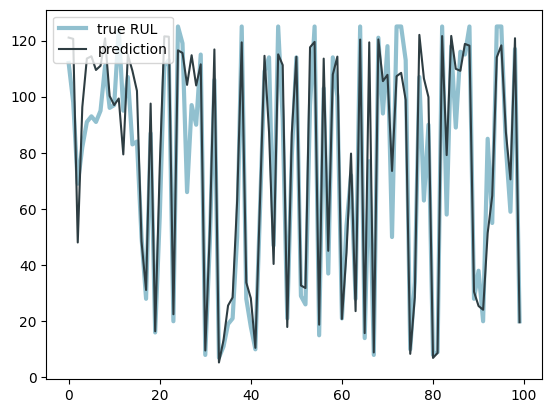

In [ ]:
mus, sigmas = get_predictions_ensemble(prediction_fns2, x_test, y_test, settings['model_name'], True)

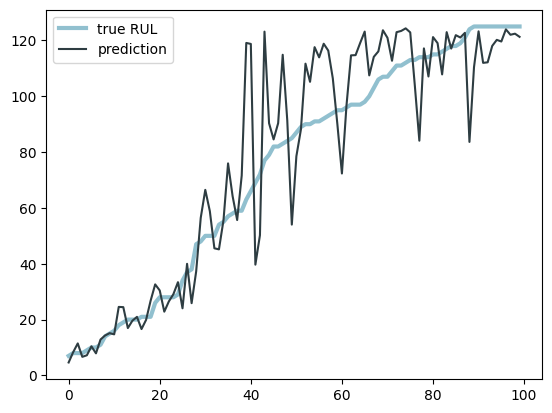

In [ ]:
plot_sorted(mus, y_test, settings['model_name'], True)

In [ ]:
import pickle
outputs_base = []

for p in prediction_fns2:
  outputs_base.append(p(x_test))

filehandler = open(b"/content/drive/MyDrive/pickled_predictions_new/outputs_base.pkl","ab")
pickle.dump(outputs_base,filehandler)

### Ensemble VAR1

In [ ]:
dataset = 'FD001'
# files
dir_path = '/content/drive/MyDrive/CMAPSSData/'



# data readout
sensor_names  = ["tfan_in_tot", "tLPC_out_tot", "tHPC_out_tot",
           "tLPT_out_tot", "pfan_in", "pbypass_tot", "pHPC_out_tot", "fan_speed_physical", "core_speed_physical",
           "P50_P2_ratio", "pHPC_out_stat", "fuel_flow_to_Ps30", "fan_speed_corrected", "core_speed_corrected",
           "bypass_ratio", "burnerfuel_air_ratio", "bleed_enthalpy", "fan_speed_demanded", "fan_speed_demanded_corrected" ,
           "HPT_coolant_bleed", "LPT_coolant_bleed"]


sensors = ['tLPC_out_tot', 'tHPC_out_tot', 'tLPT_out_tot', 'pbypass_tot',
       'pHPC_out_tot', 'fan_speed_physical', 'core_speed_physical',
       'pHPC_out_stat', 'fuel_flow_to_Ps30', 'fan_speed_corrected',
       'core_speed_corrected', 'bypass_ratio', 'bleed_enthalpy',
       'HPT_coolant_bleed', 'LPT_coolant_bleed']




In [ ]:
disable_eager_execution()




x_train, y_train, x_val, y_val, x_test, y_test, X_train_pre, X_test_pre = process_data_standard(dataset, sensors, dir_path, 'regr')
settings = {'model_name': 'LSTM_var1', 'window_length' : 30, 'batch_size' : 128, 'lstm1' : 32, 'lstm2' : 16, 'lstm3': 'no', 'dropout':'no', 'convolution':'no',
            'shape_1' :  32, 'gaussiann_layer': 1, 'sensors':sensors, 'monitor':'val_loss'}

tf.keras.utils.set_random_seed(237)
start_time = time.time()
prediction_fns2 = []
for i in range(10):
    prediction_fns2.append(create_trained_network(x_train, y_train, i))

end_time = time.time()
run_time = end_time - start_time
settings['time'] = run_time


RMSE with clipped RUL is 13.799955651089167
RMSE with clipped RUL is 15.122871908546703


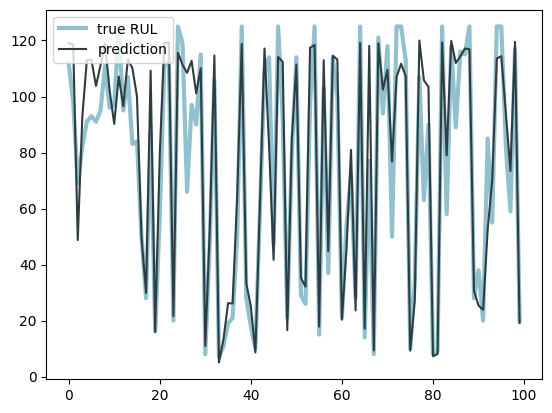

In [ ]:
mus, sigmas = get_predictions_ensemble(prediction_fns2, x_test, y_test, settings['model_name'], True)

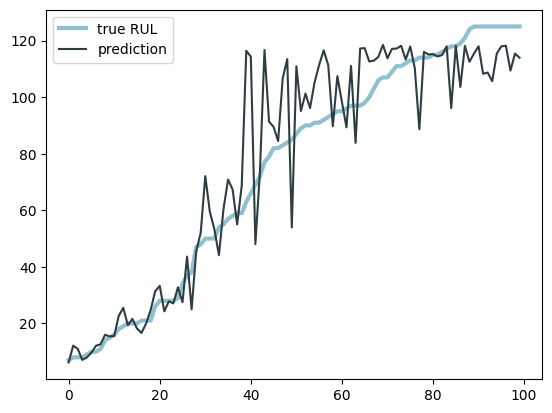

In [ ]:
plot_sorted(mus, y_test, settings['model_name'], True)

In [ ]:
import pickle
outputs_base = []

for p in prediction_fns2:
  outputs_base.append(p(x_test))

filehandler = open(b"/content/drive/MyDrive/pickled_predictions_new/outputs_var1.pkl","ab")
pickle.dump(outputs_base,filehandler)

### Ensemble VAR2

In [ ]:
dataset = 'FD001'
# files
dir_path = '/content/drive/MyDrive/CMAPSSData/'



# data readout
sensor_names  = ["tfan_in_tot", "tLPC_out_tot", "tHPC_out_tot",
           "tLPT_out_tot", "pfan_in", "pbypass_tot", "pHPC_out_tot", "fan_speed_physical", "core_speed_physical",
           "P50_P2_ratio", "pHPC_out_stat", "fuel_flow_to_Ps30", "fan_speed_corrected", "core_speed_corrected",
           "bypass_ratio", "burnerfuel_air_ratio", "bleed_enthalpy", "fan_speed_demanded", "fan_speed_demanded_corrected" ,
           "HPT_coolant_bleed", "LPT_coolant_bleed"]


sensors = ['tLPC_out_tot', 'tHPC_out_tot', 'tLPT_out_tot', 'pbypass_tot',
       'pHPC_out_tot', 'fan_speed_physical', 'core_speed_physical',
       'pHPC_out_stat', 'fuel_flow_to_Ps30', 'fan_speed_corrected',
       'core_speed_corrected', 'bypass_ratio', 'bleed_enthalpy',
       'HPT_coolant_bleed', 'LPT_coolant_bleed']




In [ ]:
disable_eager_execution()




x_train, y_train, x_val, y_val, x_test, y_test, X_train_pre, X_test_pre = process_data_standard(dataset, sensors, dir_path, 'regr')
settings = {'model_name': 'LSTM_var2', 'window_length' : 30, 'batch_size' : 256, 'lstm1' : 32, 'lstm2' : 16, 'lstm3': 'no', 'dropout':'no', 'convolution':'no',
            'shape_1' :  32, 'gaussiann_layer': 1, 'sensors':sensors, 'monitor':'val_loss'}

tf.keras.utils.set_random_seed(237)
start_time = time.time()
prediction_fns2 = []
for i in range(10):
    prediction_fns2.append(create_trained_network(x_train, y_train, i))

end_time = time.time()
run_time = end_time - start_time
settings['time'] = run_time


RMSE with clipped RUL is 13.648666881123786
RMSE with clipped RUL is 15.1946819186335


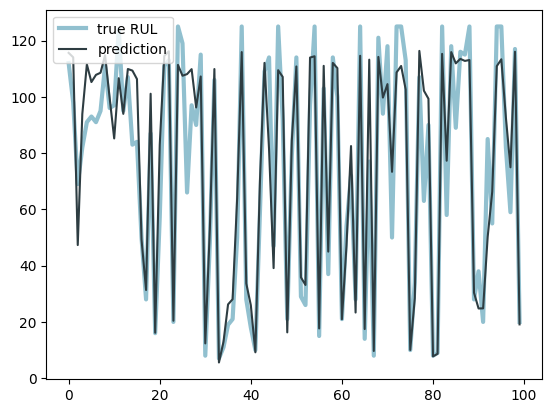

In [ ]:
mus, sigmas = get_predictions_ensemble(prediction_fns2, x_test, y_test, settings['model_name'], True)

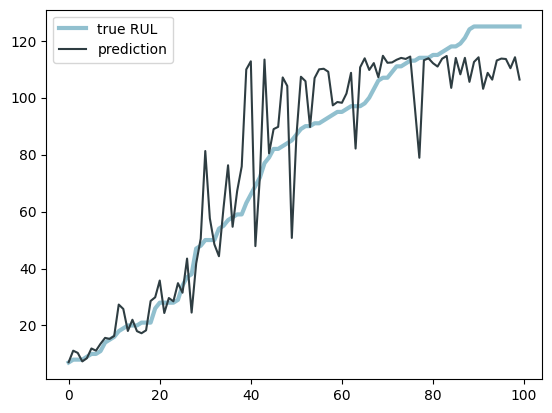

In [ ]:
plot_sorted(mus, y_test, settings['model_name'], True)

In [ ]:
import pickle
outputs_base = []

for p in prediction_fns2:
  outputs_base.append(p(x_test))

filehandler = open(b"/content/drive/MyDrive/pickled_predictions_new/outputs_var2.pkl","ab")
pickle.dump(outputs_base,filehandler)

### Ensemble VAR3

In [ ]:
def create_trained_network1(X_train, y_train, iter_num):

    callback =tf.keras.callbacks.EarlyStopping(monitor=settings['monitor'], start_from_epoch=35, patience=3)
    checkpoint_path = f"base_training_{iter_num}]/cp.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)

    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                    save_weights_only=True,
                                                    verbose=1, monitor=settings['monitor'] ,save_best_only=True)


    inputs = Input(shape=(settings['window_length'], len(settings['sensors'])))

    x = LSTM(settings['lstm1'],  return_sequences=True)(inputs)
    x = LSTM(settings['lstm2'], return_sequences=True)(x)
    x = LSTM(settings['lstm3'], )(x)

    x = Dense(settings['shape_1'], activation='relu')(x)
    mu, sigma = GaussianLayer(settings['gaussiann_layer'], name='main_output')(x)
    layer_name = 'main_output' # Where to extract the output from

    model = Model(inputs, mu)

    model.compile(loss=custom_loss(sigma), optimizer='adam', metrics=['mse'])
    print(model.summary())

    history = model.fit(x_train, y_train, epochs=100,
                  validation_data = (x_val, y_val),
                  callbacks = [callback, cp_callback,
                            ],
                  batch_size = settings['batch_size'], verbose = 2)

    pickle.dump( (history.history, settings), open(f"/content/drive/MyDrive/pickled_history_new/{settings['model_name']}_history.pkl", 'ab'))

    print(checkpoint_path)
    model.load_weights(checkpoint_path)
    get_intermediate = K.function(inputs=[model.input], outputs=model.get_layer(layer_name).output)

    return get_intermediate

In [ ]:
dataset = 'FD001'
# files
dir_path = '/content/drive/MyDrive/CMAPSSData/'



# data readout
sensor_names  = ["tfan_in_tot", "tLPC_out_tot", "tHPC_out_tot",
           "tLPT_out_tot", "pfan_in", "pbypass_tot", "pHPC_out_tot", "fan_speed_physical", "core_speed_physical",
           "P50_P2_ratio", "pHPC_out_stat", "fuel_flow_to_Ps30", "fan_speed_corrected", "core_speed_corrected",
           "bypass_ratio", "burnerfuel_air_ratio", "bleed_enthalpy", "fan_speed_demanded", "fan_speed_demanded_corrected" ,
           "HPT_coolant_bleed", "LPT_coolant_bleed"]


sensors = ['tLPC_out_tot', 'tHPC_out_tot', 'tLPT_out_tot', 'pbypass_tot',
       'pHPC_out_tot', 'fan_speed_physical', 'core_speed_physical',
       'pHPC_out_stat', 'fuel_flow_to_Ps30', 'fan_speed_corrected',
       'core_speed_corrected', 'bypass_ratio', 'bleed_enthalpy',
       'HPT_coolant_bleed', 'LPT_coolant_bleed']




In [ ]:
disable_eager_execution()




x_train, y_train, x_val, y_val, x_test, y_test, X_train_pre, X_test_pre = process_data_standard(dataset, sensors, dir_path, 'regr')
settings = {'model_name': 'LSTM_var3', 'window_length' : 30, 'batch_size' : 64, 'lstm1' : 64, 'lstm2' : 32, 'lstm3': 16, 'dropout':'no', 'convolution':'no',
            'shape_1' :  32, 'gaussiann_layer': 1, 'sensors':sensors, 'monitor':'val_loss'}

tf.keras.utils.set_random_seed(237)
start_time = time.time()
prediction_fns2 = []
for i in range(10):
    prediction_fns2.append(create_trained_network1(x_train, y_train, i))

end_time = time.time()
run_time = end_time - start_time
settings['time'] = run_time


RMSE with clipped RUL is 13.412379090487626
RMSE with clipped RUL is 14.439656457617682


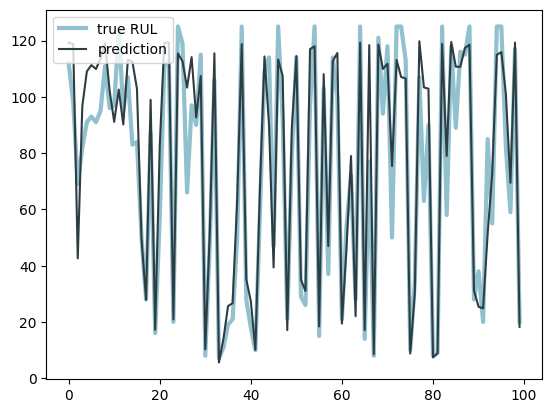

In [ ]:
mus, sigmas = get_predictions_ensemble(prediction_fns2, x_test, y_test, settings['model_name'], True)

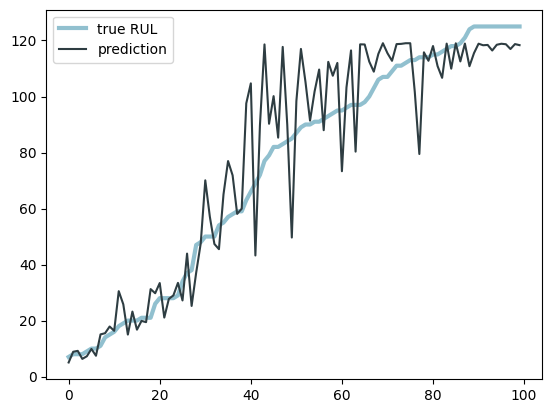

In [ ]:
plot_sorted(mus, y_test, settings['model_name'], True)

In [ ]:
import pickle
outputs_base = []

for p in prediction_fns2:
  outputs_base.append(p(x_test))

filehandler = open(b"/content/drive/MyDrive/pickled_predictions_new/outputs_var3.pkl","ab")
pickle.dump(outputs_base,filehandler)

### Ensemble VAR4

In [ ]:
dataset = 'FD001'
# files
dir_path = '/content/drive/MyDrive/CMAPSSData/'



# data readout
sensor_names  = ["tfan_in_tot", "tLPC_out_tot", "tHPC_out_tot",
           "tLPT_out_tot", "pfan_in", "pbypass_tot", "pHPC_out_tot", "fan_speed_physical", "core_speed_physical",
           "P50_P2_ratio", "pHPC_out_stat", "fuel_flow_to_Ps30", "fan_speed_corrected", "core_speed_corrected",
           "bypass_ratio", "burnerfuel_air_ratio", "bleed_enthalpy", "fan_speed_demanded", "fan_speed_demanded_corrected" ,
           "HPT_coolant_bleed", "LPT_coolant_bleed"]


sensors = ['tLPC_out_tot', 'tHPC_out_tot', 'tLPT_out_tot', 'pbypass_tot',
       'pHPC_out_tot', 'fan_speed_physical', 'core_speed_physical',
       'pHPC_out_stat', 'fuel_flow_to_Ps30', 'fan_speed_corrected',
       'core_speed_corrected', 'bypass_ratio', 'bleed_enthalpy',
       'HPT_coolant_bleed', 'LPT_coolant_bleed']




In [ ]:
disable_eager_execution()




x_train, y_train, x_val, y_val, x_test, y_test, X_train_pre, X_test_pre = process_data_standard(dataset, sensors, dir_path, 'regr')
settings = {'model_name': 'LSTM_var4', 'window_length' : 30, 'batch_size' : 128, 'lstm1' : 64, 'lstm2' : 32, 'lstm3': 16, 'dropout':'no', 'convolution':'no',
            'shape_1' :  32, 'gaussiann_layer': 1, 'sensors':sensors, 'monitor':'val_loss'}

tf.keras.utils.set_random_seed(237)
start_time = time.time()
prediction_fns2 = []
for i in range(10):
    prediction_fns2.append(create_trained_network1(x_train, y_train, i))

end_time = time.time()
run_time = end_time - start_time
settings['time'] = run_time


RMSE with clipped RUL is 13.033981394336035
RMSE with clipped RUL is 14.349845458929977


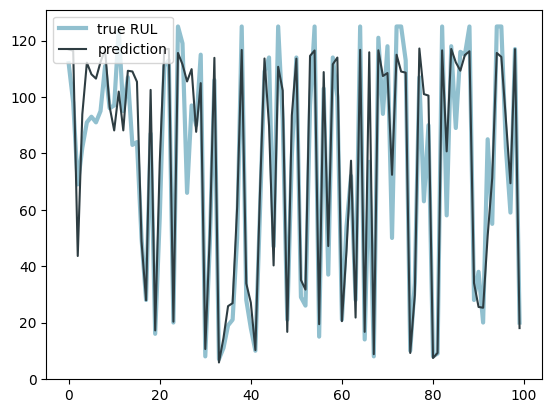

In [ ]:
mus, sigmas = get_predictions_ensemble(prediction_fns2, x_test, y_test, settings['model_name'], True)

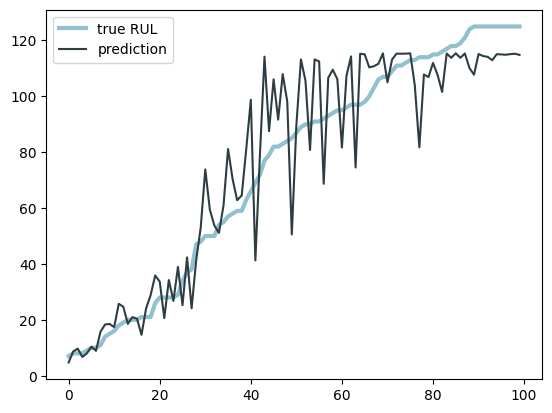

In [ ]:
plot_sorted(mus, y_test, settings['model_name'], True)

In [ ]:
import pickle
outputs_base = []

for p in prediction_fns2:
  outputs_base.append(p(x_test))

filehandler = open(b"/content/drive/MyDrive/pickled_predictions_new/outputs_var4.pkl","ab")
pickle.dump(outputs_base,filehandler)

### Ensemble VAR5

In [ ]:
dataset = 'FD001'
# files
dir_path = '/content/drive/MyDrive/CMAPSSData/'



# data readout
sensor_names  = ["tfan_in_tot", "tLPC_out_tot", "tHPC_out_tot",
           "tLPT_out_tot", "pfan_in", "pbypass_tot", "pHPC_out_tot", "fan_speed_physical", "core_speed_physical",
           "P50_P2_ratio", "pHPC_out_stat", "fuel_flow_to_Ps30", "fan_speed_corrected", "core_speed_corrected",
           "bypass_ratio", "burnerfuel_air_ratio", "bleed_enthalpy", "fan_speed_demanded", "fan_speed_demanded_corrected" ,
           "HPT_coolant_bleed", "LPT_coolant_bleed"]


sensors = ['tLPC_out_tot', 'tHPC_out_tot', 'tLPT_out_tot', 'pbypass_tot',
       'pHPC_out_tot', 'fan_speed_physical', 'core_speed_physical',
       'pHPC_out_stat', 'fuel_flow_to_Ps30', 'fan_speed_corrected',
       'core_speed_corrected', 'bypass_ratio', 'bleed_enthalpy',
       'HPT_coolant_bleed', 'LPT_coolant_bleed']




In [ ]:
disable_eager_execution()




x_train, y_train, x_val, y_val, x_test, y_test, X_train_pre, X_test_pre = process_data_standard(dataset, sensors, dir_path, 'regr')
settings = {'model_name': 'LSTM_var5', 'window_length' : 30, 'batch_size' : 256, 'lstm1' : 64, 'lstm2' : 32, 'lstm3': 16, 'dropout':'no', 'convolution':'no',
            'shape_1' :  32, 'gaussiann_layer': 1, 'sensors':sensors, 'monitor':'val_loss'}

tf.keras.utils.set_random_seed(237)
start_time = time.time()
prediction_fns2 = []
for i in range(10):
    prediction_fns2.append(create_trained_network1(x_train, y_train, i))

end_time = time.time()
run_time = end_time - start_time
settings['time'] = run_time


RMSE with clipped RUL is 14.81774139067342
RMSE with clipped RUL is 16.120197768110216


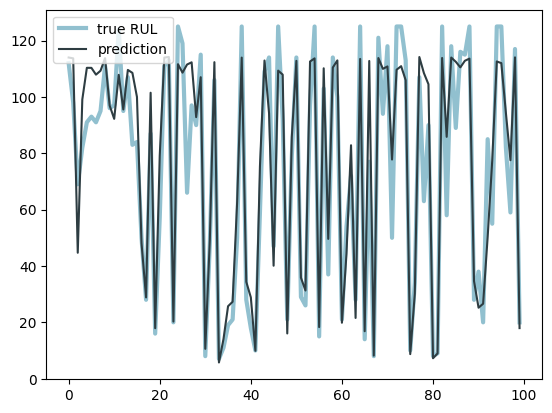

In [ ]:
mus, sigmas = get_predictions_ensemble(prediction_fns2, x_test, y_test, settings['model_name'], True)

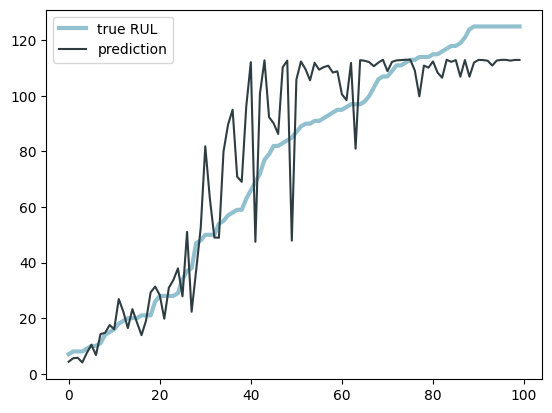

In [ ]:
plot_sorted(mus, y_test, settings['model_name'], True)

In [ ]:
import pickle
outputs_base = []

for p in prediction_fns2:
  outputs_base.append(p(x_test))

filehandler = open(b"/content/drive/MyDrive/pickled_predictions_new/outputs_var5.pkl","ab")
pickle.dump(outputs_base,filehandler)

### Ensemble VAR6

In [ ]:
def create_trained_network2(X_train, y_train, iter_num):

    callback =tf.keras.callbacks.EarlyStopping(monitor=settings['monitor'], start_from_epoch=35, patience=3)
    checkpoint_path = f"base_training_{iter_num}]/cp.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)

    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                    save_weights_only=True,
                                                    verbose=1, monitor=settings['monitor'] ,save_best_only=True)


    inputs = Input(shape=(settings['window_length'], len(settings['sensors'])))

    x = Bidirectional(LSTM(settings['lstm1'],  return_sequences=True))(inputs)
    x = Bidirectional(LSTM(settings['lstm2'], ))(x)

    x = Dense(settings['shape_1'], activation='relu')(x)
    mu, sigma = GaussianLayer(settings['gaussiann_layer'], name='main_output')(x)
    layer_name = 'main_output' # Where to extract the output from

    model = Model(inputs, mu)

    model.compile(loss=custom_loss(sigma), optimizer='adam', metrics=['mse'])
    print(model.summary())

    history = model.fit(x_train, y_train, epochs=100,
                  validation_data = (x_val, y_val),
                  callbacks = [callback, cp_callback,
                            ],
                  batch_size = settings['batch_size'], verbose = 2)

    pickle.dump( (history.history, settings), open(f"/content/drive/MyDrive/pickled_history_new/{settings['model_name']}_history.pkl", 'ab'))

    print(checkpoint_path)
    model.load_weights(checkpoint_path)
    get_intermediate = K.function(inputs=[model.input], outputs=model.get_layer(layer_name).output)

    return get_intermediate

In [ ]:
dataset = 'FD001'
# files
dir_path = '/content/drive/MyDrive/CMAPSSData/'



# data readout
sensor_names  = ["tfan_in_tot", "tLPC_out_tot", "tHPC_out_tot",
           "tLPT_out_tot", "pfan_in", "pbypass_tot", "pHPC_out_tot", "fan_speed_physical", "core_speed_physical",
           "P50_P2_ratio", "pHPC_out_stat", "fuel_flow_to_Ps30", "fan_speed_corrected", "core_speed_corrected",
           "bypass_ratio", "burnerfuel_air_ratio", "bleed_enthalpy", "fan_speed_demanded", "fan_speed_demanded_corrected" ,
           "HPT_coolant_bleed", "LPT_coolant_bleed"]


sensors = ['tLPC_out_tot', 'tHPC_out_tot', 'tLPT_out_tot', 'pbypass_tot',
       'pHPC_out_tot', 'fan_speed_physical', 'core_speed_physical',
       'pHPC_out_stat', 'fuel_flow_to_Ps30', 'fan_speed_corrected',
       'core_speed_corrected', 'bypass_ratio', 'bleed_enthalpy',
       'HPT_coolant_bleed', 'LPT_coolant_bleed']




In [ ]:
disable_eager_execution()




x_train, y_train, x_val, y_val, x_test, y_test, X_train_pre, X_test_pre = process_data_standard(dataset, sensors, dir_path, 'regr')
settings = {'model_name': 'LSTM_var6BI', 'window_length' : 30, 'batch_size' : 64, 'lstm1' : 64, 'lstm2' : 32, 'lstm3': 'no', 'dropout':'no', 'convolution':'no',
            'shape_1' :  32, 'gaussiann_layer': 1, 'sensors':sensors, 'monitor':'val_loss'}

tf.keras.utils.set_random_seed(237)
start_time = time.time()
prediction_fns2 = []
for i in range(10):
    prediction_fns2.append(create_trained_network2(x_train, y_train, i))

end_time = time.time()
run_time = end_time - start_time
settings['time'] = run_time


RMSE with clipped RUL is 14.360316708748835
RMSE with clipped RUL is 15.569039099340447


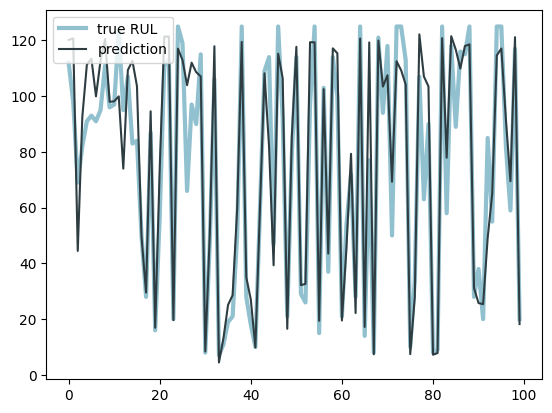

In [ ]:
mus, sigmas = get_predictions_ensemble(prediction_fns2, x_test, y_test, settings['model_name'], True)

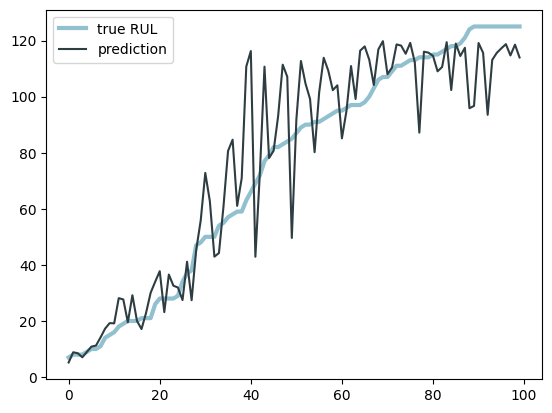

In [ ]:
plot_sorted(mus, y_test, settings['model_name'], True)

In [ ]:
import pickle
outputs_base = []

for p in prediction_fns2:
  outputs_base.append(p(x_test))

filehandler = open(b"/content/drive/MyDrive/pickled_predictions_new/outputs_var6.pkl","ab")
pickle.dump(outputs_base,filehandler)

### Ensemble VAR7

In [ ]:
dataset = 'FD001'
# files
dir_path = '/content/drive/MyDrive/CMAPSSData/'



# data readout
sensor_names  = ["tfan_in_tot", "tLPC_out_tot", "tHPC_out_tot",
           "tLPT_out_tot", "pfan_in", "pbypass_tot", "pHPC_out_tot", "fan_speed_physical", "core_speed_physical",
           "P50_P2_ratio", "pHPC_out_stat", "fuel_flow_to_Ps30", "fan_speed_corrected", "core_speed_corrected",
           "bypass_ratio", "burnerfuel_air_ratio", "bleed_enthalpy", "fan_speed_demanded", "fan_speed_demanded_corrected" ,
           "HPT_coolant_bleed", "LPT_coolant_bleed"]


sensors = ['tLPC_out_tot', 'tHPC_out_tot', 'tLPT_out_tot', 'pbypass_tot',
       'pHPC_out_tot', 'fan_speed_physical', 'core_speed_physical',
       'pHPC_out_stat', 'fuel_flow_to_Ps30', 'fan_speed_corrected',
       'core_speed_corrected', 'bypass_ratio', 'bleed_enthalpy',
       'HPT_coolant_bleed', 'LPT_coolant_bleed']




In [ ]:
disable_eager_execution()




x_train, y_train, x_val, y_val, x_test, y_test, X_train_pre, X_test_pre = process_data_standard(dataset, sensors, dir_path, 'regr')
settings = {'model_name': 'LSTM_var7BI', 'window_length' : 30, 'batch_size' : 128, 'lstm1' : 64, 'lstm2' : 32, 'lstm3': 'no', 'dropout':'no', 'convolution':'no',
            'shape_1' :  32, 'gaussiann_layer': 1, 'sensors':sensors, 'monitor':'val_loss'}

tf.keras.utils.set_random_seed(237)
start_time = time.time()
prediction_fns2 = []
for i in range(10):
    prediction_fns2.append(create_trained_network2(x_train, y_train, i))

end_time = time.time()
run_time = end_time - start_time
settings['time'] = run_time


RMSE with clipped RUL is 15.520953899341931
RMSE with clipped RUL is 16.419436424047547


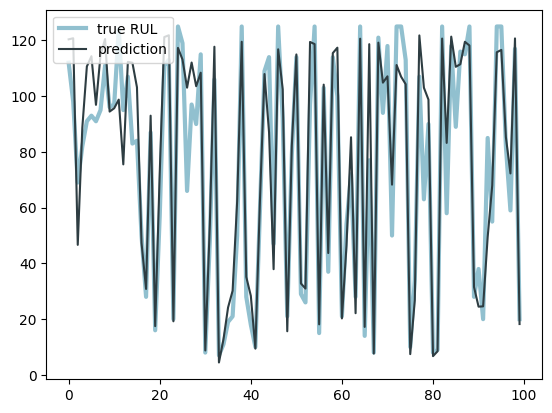

In [ ]:
mus, sigmas = get_predictions_ensemble(prediction_fns2, x_test, y_test, settings['model_name'], True)

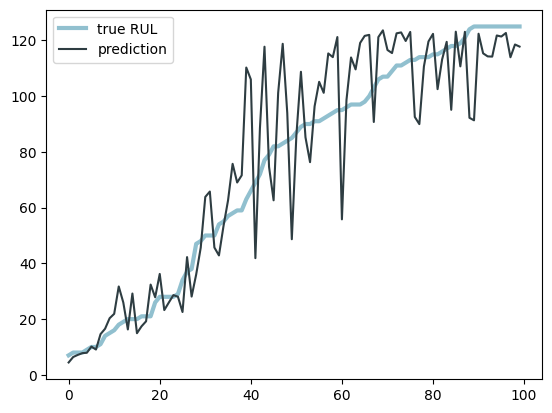

In [ ]:
plot_sorted(mus, y_test, settings['model_name'], True)

In [ ]:
import pickle
outputs_base = []

for p in prediction_fns2:
  outputs_base.append(p(x_test))

filehandler = open(b"/content/drive/MyDrive/pickled_predictions_new/outputs_var7.pkl","ab")
pickle.dump(outputs_base,filehandler)

### Ensemble VAR8

In [ ]:
dataset = 'FD001'
# files
dir_path = '/content/drive/MyDrive/CMAPSSData/'



# data readout
sensor_names  = ["tfan_in_tot", "tLPC_out_tot", "tHPC_out_tot",
           "tLPT_out_tot", "pfan_in", "pbypass_tot", "pHPC_out_tot", "fan_speed_physical", "core_speed_physical",
           "P50_P2_ratio", "pHPC_out_stat", "fuel_flow_to_Ps30", "fan_speed_corrected", "core_speed_corrected",
           "bypass_ratio", "burnerfuel_air_ratio", "bleed_enthalpy", "fan_speed_demanded", "fan_speed_demanded_corrected" ,
           "HPT_coolant_bleed", "LPT_coolant_bleed"]


sensors = ['tLPC_out_tot', 'tHPC_out_tot', 'tLPT_out_tot', 'pbypass_tot',
       'pHPC_out_tot', 'fan_speed_physical', 'core_speed_physical',
       'pHPC_out_stat', 'fuel_flow_to_Ps30', 'fan_speed_corrected',
       'core_speed_corrected', 'bypass_ratio', 'bleed_enthalpy',
       'HPT_coolant_bleed', 'LPT_coolant_bleed']




In [ ]:
disable_eager_execution()




x_train, y_train, x_val, y_val, x_test, y_test, X_train_pre, X_test_pre = process_data_standard(dataset, sensors, dir_path, 'regr')
settings = {'model_name': 'LSTM_var8BI', 'window_length' : 30, 'batch_size' : 256, 'lstm1' : 64, 'lstm2' : 32, 'lstm3': 'no', 'dropout':'no', 'convolution':'no',
            'shape_1' :  32, 'gaussiann_layer': 1, 'sensors':sensors, 'monitor':'val_loss'}

tf.keras.utils.set_random_seed(237)
start_time = time.time()
prediction_fns2 = []
for i in range(10):
    prediction_fns2.append(create_trained_network2(x_train, y_train, i))

end_time = time.time()
run_time = end_time - start_time
settings['time'] = run_time


RMSE with clipped RUL is 13.99383128026971
RMSE with clipped RUL is 15.090173701552867


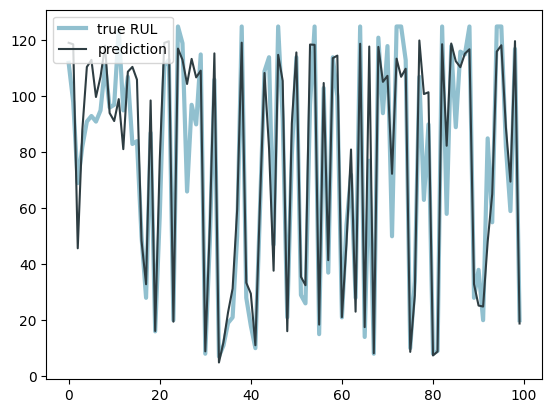

In [ ]:
mus, sigmas = get_predictions_ensemble(prediction_fns2, x_test, y_test, settings['model_name'], True)

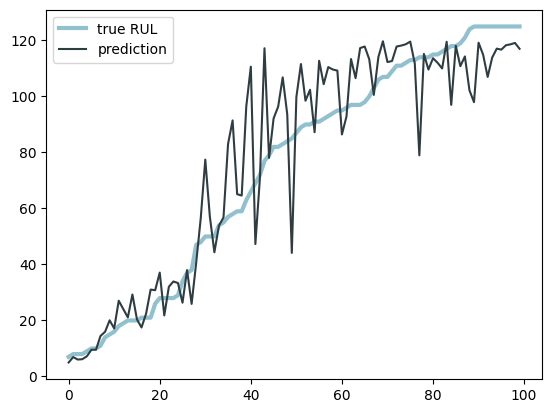

In [ ]:
plot_sorted(mus, y_test, settings['model_name'], True)

In [ ]:
import pickle
outputs_base = []

for p in prediction_fns2:
  outputs_base.append(p(x_test))

filehandler = open(b"/content/drive/MyDrive/pickled_predictions_new/outputs_var8.pkl","ab")
pickle.dump(outputs_base,filehandler)

### Ensemble VAR9

In [ ]:
def create_trained_network3(X_train, y_train, iter_num):

    callback =tf.keras.callbacks.EarlyStopping(monitor=settings['monitor'], start_from_epoch=35, patience=3)
    checkpoint_path = f"base_training_{iter_num}]/cp.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)

    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                    save_weights_only=True,
                                                    verbose=1, monitor=settings['monitor'] ,save_best_only=True)


    inputs = Input(shape=(settings['window_length'], len(settings['sensors'])))

    x = Bidirectional(LSTM(settings['lstm1'],  return_sequences=True))(inputs)
    x = Bidirectional(LSTM(settings['lstm2'], return_sequences=True))(x)
    x = Bidirectional(LSTM(settings['lstm3'], ))(x)

    x = Dense(settings['shape_1'], activation='relu')(x)
    mu, sigma = GaussianLayer(settings['gaussiann_layer'], name='main_output')(x)
    layer_name = 'main_output' # Where to extract the output from

    model = Model(inputs, mu)

    model.compile(loss=custom_loss(sigma), optimizer='adam', metrics=['mse'])
    print(model.summary())

    history = model.fit(x_train, y_train, epochs=100,
                  validation_data = (x_val, y_val),
                  callbacks = [callback, cp_callback,
                            ],
                  batch_size = settings['batch_size'], verbose = 2)

    pickle.dump( (history.history, settings), open(f"/content/drive/MyDrive/pickled_history_new/{settings['model_name']}_history.pkl", 'ab'))

    print(checkpoint_path)
    model.load_weights(checkpoint_path)
    get_intermediate = K.function(inputs=[model.input], outputs=model.get_layer(layer_name).output)

    return get_intermediate

In [ ]:
dataset = 'FD001'
# files
dir_path = '/content/drive/MyDrive/CMAPSSData/'



# data readout
sensor_names  = ["tfan_in_tot", "tLPC_out_tot", "tHPC_out_tot",
           "tLPT_out_tot", "pfan_in", "pbypass_tot", "pHPC_out_tot", "fan_speed_physical", "core_speed_physical",
           "P50_P2_ratio", "pHPC_out_stat", "fuel_flow_to_Ps30", "fan_speed_corrected", "core_speed_corrected",
           "bypass_ratio", "burnerfuel_air_ratio", "bleed_enthalpy", "fan_speed_demanded", "fan_speed_demanded_corrected" ,
           "HPT_coolant_bleed", "LPT_coolant_bleed"]


sensors = ['tLPC_out_tot', 'tHPC_out_tot', 'tLPT_out_tot', 'pbypass_tot',
       'pHPC_out_tot', 'fan_speed_physical', 'core_speed_physical',
       'pHPC_out_stat', 'fuel_flow_to_Ps30', 'fan_speed_corrected',
       'core_speed_corrected', 'bypass_ratio', 'bleed_enthalpy',
       'HPT_coolant_bleed', 'LPT_coolant_bleed']




In [ ]:
disable_eager_execution()




x_train, y_train, x_val, y_val, x_test, y_test, X_train_pre, X_test_pre = process_data_standard(dataset, sensors, dir_path, 'regr')
settings = {'model_name': 'LSTM_var9BI', 'window_length' : 30, 'batch_size' : 64, 'lstm1' : 64, 'lstm2' : 32, 'lstm3': 16, 'dropout':'no', 'convolution':'no',
            'shape_1' :  32, 'gaussiann_layer': 1, 'sensors':sensors, 'monitor':'val_loss'}

tf.keras.utils.set_random_seed(237)
start_time = time.time()
prediction_fns2 = []
for i in range(10):
    prediction_fns2.append(create_trained_network3(x_train, y_train, i))

end_time = time.time()
run_time = end_time - start_time
settings['time'] = run_time


RMSE with clipped RUL is 13.917897867249884
RMSE with clipped RUL is 15.141117789225884


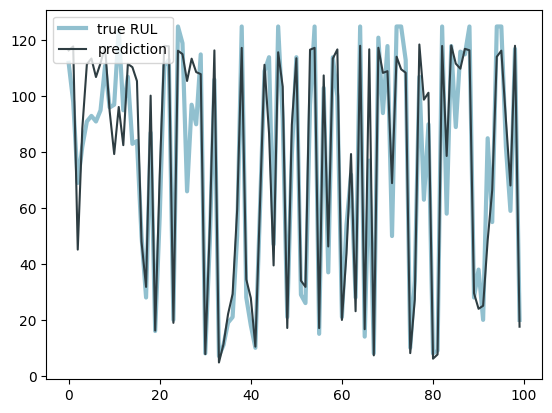

In [ ]:
mus, sigmas = get_predictions_ensemble(prediction_fns2, x_test, y_test, settings['model_name'], True)

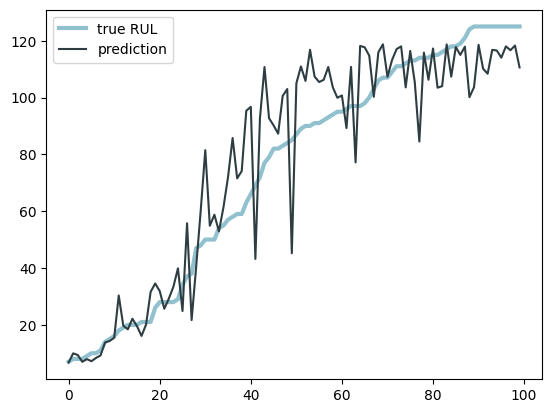

In [ ]:
plot_sorted(mus, y_test, settings['model_name'], True)

In [ ]:
import pickle
outputs_base = []

for p in prediction_fns2:
  outputs_base.append(p(x_test))

filehandler = open(b"/content/drive/MyDrive/pickled_predictions_new/outputs_var9.pkl","ab")
pickle.dump(outputs_base,filehandler)

### Ensemble VAR10


In [ ]:
dataset = 'FD001'
# files
dir_path = '/content/drive/MyDrive/CMAPSSData/'



# data readout
sensor_names  = ["tfan_in_tot", "tLPC_out_tot", "tHPC_out_tot",
           "tLPT_out_tot", "pfan_in", "pbypass_tot", "pHPC_out_tot", "fan_speed_physical", "core_speed_physical",
           "P50_P2_ratio", "pHPC_out_stat", "fuel_flow_to_Ps30", "fan_speed_corrected", "core_speed_corrected",
           "bypass_ratio", "burnerfuel_air_ratio", "bleed_enthalpy", "fan_speed_demanded", "fan_speed_demanded_corrected" ,
           "HPT_coolant_bleed", "LPT_coolant_bleed"]


sensors = ['tLPC_out_tot', 'tHPC_out_tot', 'tLPT_out_tot', 'pbypass_tot',
       'pHPC_out_tot', 'fan_speed_physical', 'core_speed_physical',
       'pHPC_out_stat', 'fuel_flow_to_Ps30', 'fan_speed_corrected',
       'core_speed_corrected', 'bypass_ratio', 'bleed_enthalpy',
       'HPT_coolant_bleed', 'LPT_coolant_bleed']




In [ ]:
disable_eager_execution()




x_train, y_train, x_val, y_val, x_test, y_test, X_train_pre, X_test_pre = process_data_standard(dataset, sensors, dir_path, 'regr')
settings = {'model_name': 'LSTM_var10BI', 'window_length' : 30, 'batch_size' : 128, 'lstm1' : 64, 'lstm2' : 32, 'lstm3': 16, 'dropout':'no', 'convolution':'no',
            'shape_1' :  32, 'gaussiann_layer': 1, 'sensors':sensors, 'monitor':'val_loss'}

tf.keras.utils.set_random_seed(237)
start_time = time.time()
prediction_fns2 = []
for i in range(10):
    prediction_fns2.append(create_trained_network3(x_train, y_train, i))

end_time = time.time()
run_time = end_time - start_time
settings['time'] = run_time


RMSE with clipped RUL is 15.901224177918117
RMSE with clipped RUL is 16.631033964804704


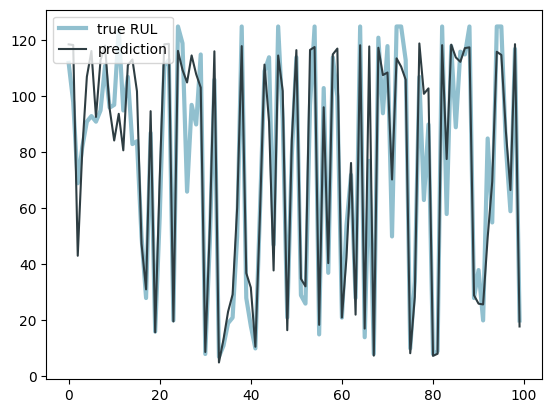

In [ ]:
mus, sigmas = get_predictions_ensemble(prediction_fns2, x_test, y_test, settings['model_name'], True)

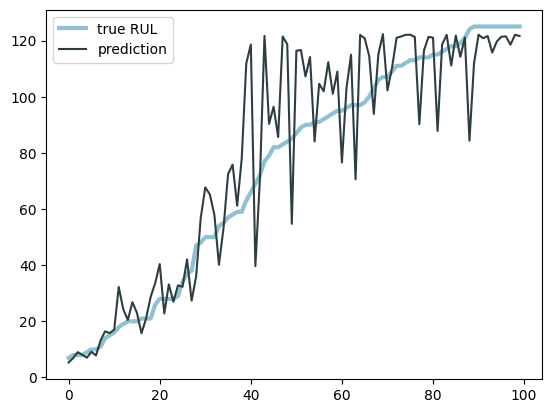

In [ ]:
plot_sorted(mus, y_test, settings['model_name'], True)

In [ ]:
import pickle
outputs_base = []

for p in prediction_fns2:
  outputs_base.append(p(x_test))

filehandler = open(b"/content/drive/MyDrive/pickled_predictions_new/outputs_var10.pkl","ab")
pickle.dump(outputs_base,filehandler)

### Ensemble VAR11

In [ ]:
dataset = 'FD001'
# files
dir_path = '/content/drive/MyDrive/CMAPSSData/'



# data readout
sensor_names  = ["tfan_in_tot", "tLPC_out_tot", "tHPC_out_tot",
           "tLPT_out_tot", "pfan_in", "pbypass_tot", "pHPC_out_tot", "fan_speed_physical", "core_speed_physical",
           "P50_P2_ratio", "pHPC_out_stat", "fuel_flow_to_Ps30", "fan_speed_corrected", "core_speed_corrected",
           "bypass_ratio", "burnerfuel_air_ratio", "bleed_enthalpy", "fan_speed_demanded", "fan_speed_demanded_corrected" ,
           "HPT_coolant_bleed", "LPT_coolant_bleed"]


sensors = ['tLPC_out_tot', 'tHPC_out_tot', 'tLPT_out_tot', 'pbypass_tot',
       'pHPC_out_tot', 'fan_speed_physical', 'core_speed_physical',
       'pHPC_out_stat', 'fuel_flow_to_Ps30', 'fan_speed_corrected',
       'core_speed_corrected', 'bypass_ratio', 'bleed_enthalpy',
       'HPT_coolant_bleed', 'LPT_coolant_bleed']




In [ ]:
disable_eager_execution()




x_train, y_train, x_val, y_val, x_test, y_test, X_train_pre, X_test_pre = process_data_standard(dataset, sensors, dir_path, 'regr')
settings = {'model_name': 'LSTM_var11BI', 'window_length' : 30, 'batch_size' : 256, 'lstm1' : 64, 'lstm2' : 32, 'lstm3': 16, 'dropout':'no', 'convolution':'no',
            'shape_1' :  32, 'gaussiann_layer': 1, 'sensors':sensors, 'monitor':'val_loss'}

tf.keras.utils.set_random_seed(237)
start_time = time.time()
prediction_fns2 = []
for i in range(10):
    prediction_fns2.append(create_trained_network3(x_train, y_train, i))

end_time = time.time()
run_time = end_time - start_time
settings['time'] = run_time


RMSE with clipped RUL is 15.344013063361064
RMSE with clipped RUL is 16.375970029904586


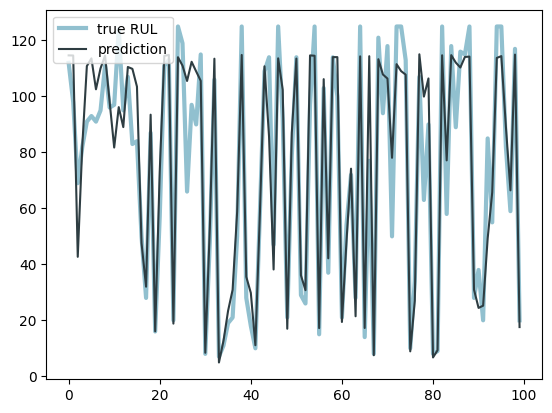

In [ ]:
mus, sigmas = get_predictions_ensemble(prediction_fns2, x_test, y_test, settings['model_name'], True)

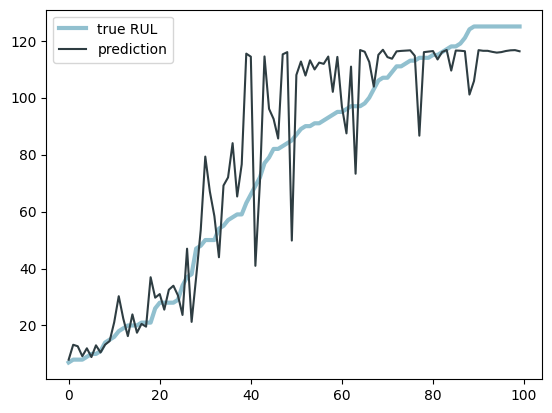

In [ ]:
plot_sorted(mus, y_test, settings['model_name'], True)

In [ ]:
import pickle
outputs_base = []

for p in prediction_fns2:
  outputs_base.append(p(x_test))

filehandler = open(b"/content/drive/MyDrive/pickled_predictions_new/outputs_var11.pkl","ab")
pickle.dump(outputs_base,filehandler)

### Var 12 + conv

In [ ]:
def create_trained_network_conv(X_train, y_train, iter_num):

    callback =tf.keras.callbacks.EarlyStopping(monitor=settings['monitor'], start_from_epoch=35, patience=6)
    checkpoint_path = f"varV3_training_{iter_num}]/cp.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)

    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                    save_weights_only=True,
                                                    verbose=1, monitor=settings['monitor'] ,save_best_only=True)
    #reduce_lr = ReduceLROnPlateau(monitor=settings['monitor'], factor=0.9, patience=3, min_lr=0.00001)

    inputs = Input(shape=(settings['window_length'], len(settings['sensors'])))
    #x = Dropout(settings['dropout'])(inputs)
    x = Conv1D(32, 3, 3)(inputs)
    x = LSTM(settings['lstm1'], return_sequences=True)(x)
    x = LSTM(settings['lstm2'], return_sequences=True)(x)
    x = LSTM(settings['lstm3'], )(x)


    x = Dense(settings['shape_1'], activation='relu',kernel_regularizer='l2')(x)
    mu, sigma = GaussianLayer(settings['gaussiann_layer'], name='main_output')(x)
    layer_name = 'main_output' # Where to extract the output from

    model = Model(inputs, mu)
    optimizer = keras.optimizers.legacy.Adam(lr=0.1)
    model.compile(loss=custom_loss(sigma), optimizer='adam', metrics=['mse'])
    print(model.summary())

    history = model.fit(x_train, y_train, epochs=100,
                  validation_data = (x_val, y_val),
                  callbacks = [callback, cp_callback, #reduce_lr
                            ],
                  batch_size = settings['batch_size'], verbose = 2)

    pickle.dump( (history.history, settings), open(f"/content/drive/MyDrive/pickled_history_new/{settings['model_name']}_history.pkl", 'ab'))

    print(checkpoint_path)
    model.load_weights(checkpoint_path)
    get_intermediate = K.function(inputs=[model.input], outputs=model.get_layer(layer_name).output)

    return get_intermediate











In [ ]:
disable_eager_execution()




x_train, y_train, x_val, y_val, x_test, y_test, X_train_pre, X_test_pre = process_data_standard(dataset, sensors, dir_path, 'regr')
settings = {'model_name': 'LSTM_var12Conv', 'window_length' : 30, 'batch_size' : 256, 'lstm1' : 64, 'lstm2' : 32, 'lstm3': 16, 'dropout':'no', 'convolution':32,
            'shape_1' :  32, 'gaussiann_layer': 1, 'sensors':sensors, 'monitor':'val_loss'}

tf.keras.utils.set_random_seed(237)
start_time = time.time()
prediction_fns2 = []
for i in range(10):
    prediction_fns2.append(create_trained_network_conv(x_train, y_train, i))

end_time = time.time()
run_time = end_time - start_time
settings['time'] = run_time


RMSE with clipped RUL is 14.26667031853634
RMSE with clipped RUL is 15.399815275049171


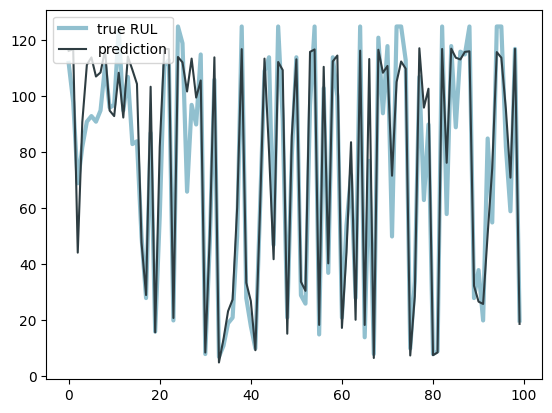

In [ ]:
mus, sigmas = get_predictions_ensemble(prediction_fns2, x_test, y_test, settings['model_name'], True)

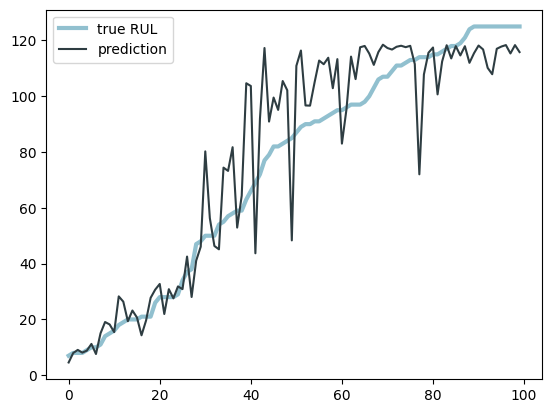

In [ ]:
plot_sorted(mus, y_test, settings['model_name'], True)

In [ ]:
import pickle
outputs_base = []

for p in prediction_fns2:
  outputs_base.append(p(x_test))

filehandler = open(b"/content/drive/MyDrive/pickled_predictions_new/outputs_var12Conv.pkl","ab")
pickle.dump(outputs_base,filehandler)

### Var 13 + conv + dropout

In [ ]:
def create_trained_network_conv2(X_train, y_train, iter_num):

    callback =tf.keras.callbacks.EarlyStopping(monitor=settings['monitor'], start_from_epoch=35, patience=6)
    checkpoint_path = f"varV3_training_{iter_num}]/cp.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)

    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                    save_weights_only=True,
                                                    verbose=1, monitor=settings['monitor'] ,save_best_only=True)
    #reduce_lr = ReduceLROnPlateau(monitor=settings['monitor'], factor=0.9, patience=3, min_lr=0.00001)

    inputs = Input(shape=(settings['window_length'], len(settings['sensors'])))
    x = Dropout(settings['dropout'])(inputs)
    x = Conv1D(32, 3, 3)(x)
    x = LSTM(settings['lstm1'],  return_sequences=True)(x)
    x = LSTM(settings['lstm2'], return_sequences=False)(x)
    #x = LSTM(settings['lstm3'], )(x)


    x = Dense(settings['shape_1'], activation='relu',kernel_regularizer='l2')(x)
    mu, sigma = GaussianLayer(settings['gaussiann_layer'], name='main_output')(x)
    layer_name = 'main_output' # Where to extract the output from

    model = Model(inputs, mu)
    optimizer = keras.optimizers.legacy.Adam(lr=0.1)
    model.compile(loss=custom_loss(sigma), optimizer='adam', metrics=['mse'])
    print(model.summary())

    history = model.fit(x_train, y_train, epochs=100,
                  validation_data = (x_val, y_val),
                  callbacks = [callback, cp_callback, #reduce_lr
                            ],
                  batch_size = settings['batch_size'], verbose = 2)

    pickle.dump( (history.history, settings), open(f"/content/drive/MyDrive/pickled_history_new/{settings['model_name']}_history.pkl", 'ab'))

    print(checkpoint_path)
    model.load_weights(checkpoint_path)
    get_intermediate = K.function(inputs=[model.input], outputs=model.get_layer(layer_name).output)

    return get_intermediate











In [ ]:
disable_eager_execution()




x_train, y_train, x_val, y_val, x_test, y_test, X_train_pre, X_test_pre = process_data_standard(dataset, sensors, dir_path, 'regr')
settings = {'model_name': 'LSTM_var12ConvDropout', 'window_length' : 30, 'batch_size' : 256, 'lstm1' : 64, 'lstm2' : 32, 'lstm3': 16, 'dropout':0.2, 'convolution':32,
            'shape_1' :  32, 'gaussiann_layer': 1, 'sensors':sensors, 'monitor':'val_loss'}

tf.keras.utils.set_random_seed(237)
start_time = time.time()
prediction_fns2 = []
for i in range(10):
    prediction_fns2.append(create_trained_network_conv2(x_train, y_train, i))

end_time = time.time()
run_time = end_time - start_time
settings['time'] = run_time


RMSE with clipped RUL is 13.339121543217239
RMSE with clipped RUL is 14.575376617678312


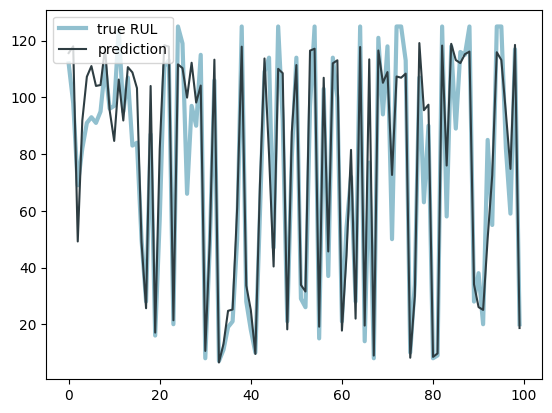

In [ ]:
mus, sigmas = get_predictions_ensemble(prediction_fns2, x_test, y_test, settings['model_name'], True)

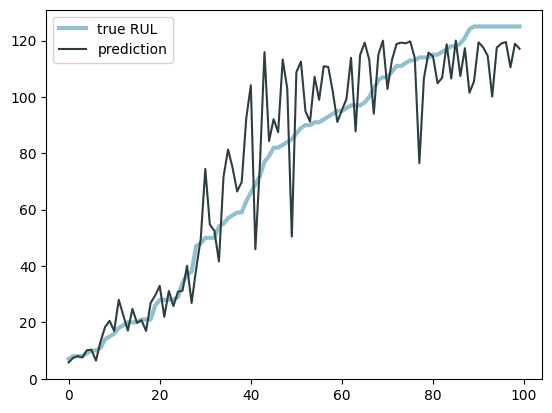

In [ ]:
plot_sorted(mus, y_test, settings['model_name'], True)

In [ ]:
import pickle
outputs_base = []

for p in prediction_fns2:
  outputs_base.append(p(x_test))

filehandler = open(b"/content/drive/MyDrive/pickled_predictions_new/outputs_var13ConvDropout.pkl","ab")
pickle.dump(outputs_base,filehandler)

# Dataset2

## Full data

In [ ]:
dataset = 'FD002'
# files
dir_path = '/content/drive/MyDrive/CMAPSSData/'



# data readout
sensor_names  = ["tfan_in_tot", "tLPC_out_tot", "tHPC_out_tot",
           "tLPT_out_tot", "pfan_in", "pbypass_tot", "pHPC_out_tot", "fan_speed_physical", "core_speed_physical",
           "P50_P2_ratio", "pHPC_out_stat", "fuel_flow_to_Ps30", "fan_speed_corrected", "core_speed_corrected",
           "bypass_ratio", "burnerfuel_air_ratio", "bleed_enthalpy", "fan_speed_demanded", "fan_speed_demanded_corrected" ,
           "HPT_coolant_bleed", "LPT_coolant_bleed"]


sensors = ['tLPC_out_tot', 'tHPC_out_tot', 'tLPT_out_tot', 'pbypass_tot',
       'pHPC_out_tot', 'fan_speed_physical', 'core_speed_physical',
       'pHPC_out_stat', 'fuel_flow_to_Ps30', 'fan_speed_corrected',
       'core_speed_corrected', 'bypass_ratio', 'bleed_enthalpy',
       'HPT_coolant_bleed', 'LPT_coolant_bleed']




In [ ]:
disable_eager_execution()




x_train, y_train, x_val, y_val, x_test, y_test, X_train_pre, X_test_pre = process_data_standard(dataset, sensors, dir_path, 'regr')
settings = {'model_name': 'DS2_LSTM_var12ConvDropout', 'window_length' : 30, 'batch_size' : 256, 'lstm1' : 64, 'lstm2' : 32, 'lstm3': 16, 'dropout':0.2, 'convolution':32,
            'shape_1' :  32, 'gaussiann_layer': 1, 'sensors':sensors, 'monitor':'val_loss'}

tf.keras.utils.set_random_seed(237)
start_time = time.time()
prediction_fns2 = []
for i in range(10):
    prediction_fns2.append(create_trained_network_conv2(x_train, y_train, i))

end_time = time.time()
run_time = end_time - start_time
settings['time'] = run_time


RMSE with clipped RUL is 22.821830100606707
RMSE with clipped RUL is 43.8357485992643


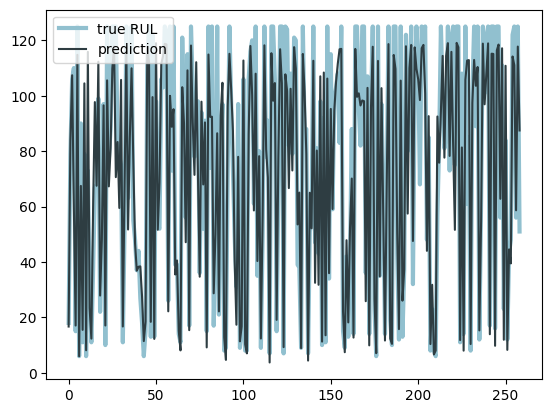

In [ ]:
mus, sigmas = get_predictions_ensemble(prediction_fns2, x_test, y_test, settings['model_name'], True)

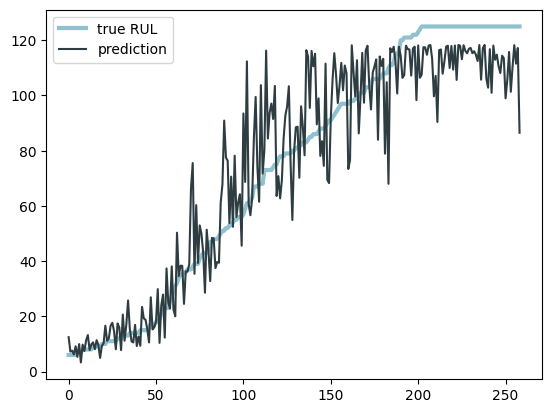

In [ ]:
plot_sorted(mus, y_test, settings['model_name'], True)

In [ ]:
import pickle
outputs_base = []

for p in prediction_fns2:
  outputs_base.append(p(x_test))

filehandler = open(b"/content/drive/MyDrive/pickled_predictions_new/DS2_outputs_var13ConvDropout.pkl","ab")
pickle.dump(outputs_base,filehandler)

## Clustered data 0

In [ ]:
dataset = 'FD002'
# files
dir_path = '/content/drive/MyDrive/CMAPSSData/'



# data readout
sensor_names  = ["tfan_in_tot", "tLPC_out_tot", "tHPC_out_tot",
           "tLPT_out_tot", "pfan_in", "pbypass_tot", "pHPC_out_tot", "fan_speed_physical", "core_speed_physical",
           "P50_P2_ratio", "pHPC_out_stat", "fuel_flow_to_Ps30", "fan_speed_corrected", "core_speed_corrected",
           "bypass_ratio", "burnerfuel_air_ratio", "bleed_enthalpy", "fan_speed_demanded", "fan_speed_demanded_corrected" ,
           "HPT_coolant_bleed", "LPT_coolant_bleed"]


sensors = ['tLPC_out_tot', 'tHPC_out_tot', 'tLPT_out_tot', 'pbypass_tot',
       'pHPC_out_tot', 'fan_speed_physical', 'core_speed_physical',
       'pHPC_out_stat', 'fuel_flow_to_Ps30', 'fan_speed_corrected',
       'core_speed_corrected', 'bypass_ratio', 'bleed_enthalpy',
       'HPT_coolant_bleed', 'LPT_coolant_bleed']




disable_eager_execution()




x_train, y_train, x_val, y_val, x_test, y_test, X_train_pre, X_test_pre = process_data_standard2(dataset, sensors, dir_path, 'regr', clust=0)
settings = {'model_name': 'DS2_Clust1_LSTM_var12ConvDropout', 'window_length' : 30, 'batch_size' : 256, 'lstm1' : 64, 'lstm2' : 32, 'lstm3': 16, 'dropout':0.2, 'convolution':32,
            'shape_1' :  32, 'gaussiann_layer': 1, 'sensors':sensors, 'monitor':'val_loss'}

tf.keras.utils.set_random_seed(237)
start_time = time.time()
prediction_fns2 = []
for i in range(10):
    prediction_fns2.append(create_trained_network_conv2(x_train, y_train, i))

end_time = time.time()
run_time = end_time - start_time
settings['time'] = run_time


RMSE with clipped RUL is 25.017138406743612
RMSE with clipped RUL is 44.71386075627283


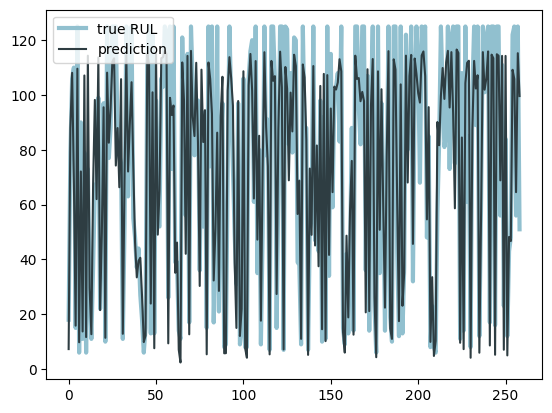

In [ ]:
mus, sigmas = get_predictions_ensemble(prediction_fns2, x_test, y_test, settings['model_name'], True)

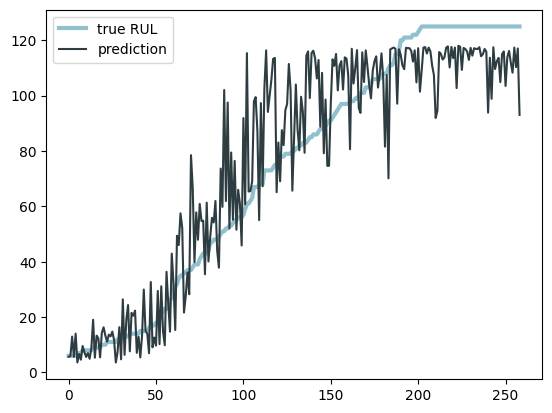

In [ ]:
plot_sorted(mus, y_test, settings['model_name'], True)

In [ ]:
import pickle
outputs_base = []

for p in prediction_fns2:
  outputs_base.append(p(x_test))

filehandler = open(b"/content/drive/MyDrive/pickled_predictions_new/DS2_clust0_outputs_var13ConvDropout.pkl","ab")
pickle.dump(outputs_base,filehandler)

## Clustered data 1

In [ ]:
dataset = 'FD002'
# files
dir_path = '/content/drive/MyDrive/CMAPSSData/'



# data readout
sensor_names  = ["tfan_in_tot", "tLPC_out_tot", "tHPC_out_tot",
           "tLPT_out_tot", "pfan_in", "pbypass_tot", "pHPC_out_tot", "fan_speed_physical", "core_speed_physical",
           "P50_P2_ratio", "pHPC_out_stat", "fuel_flow_to_Ps30", "fan_speed_corrected", "core_speed_corrected",
           "bypass_ratio", "burnerfuel_air_ratio", "bleed_enthalpy", "fan_speed_demanded", "fan_speed_demanded_corrected" ,
           "HPT_coolant_bleed", "LPT_coolant_bleed"]


sensors = ['tLPC_out_tot', 'tHPC_out_tot', 'tLPT_out_tot', 'pbypass_tot',
       'pHPC_out_tot', 'fan_speed_physical', 'core_speed_physical',
       'pHPC_out_stat', 'fuel_flow_to_Ps30', 'fan_speed_corrected',
       'core_speed_corrected', 'bypass_ratio', 'bleed_enthalpy',
       'HPT_coolant_bleed', 'LPT_coolant_bleed']




In [ ]:
disable_eager_execution()




x_train, y_train, x_val, y_val, x_test, y_test, X_train_pre, X_test_pre = process_data_standard2(dataset, sensors, dir_path, 'regr', clust=1)
settings = {'model_name': 'DS2_Clust0_LSTM_var12ConvDropout', 'window_length' : 30, 'batch_size' : 256, 'lstm1' : 64, 'lstm2' : 32, 'lstm3': 16, 'dropout':0.2, 'convolution':32,
            'shape_1' :  32, 'gaussiann_layer': 1, 'sensors':sensors, 'monitor':'val_loss'}

tf.keras.utils.set_random_seed(237)
start_time = time.time()
prediction_fns2 = []
for i in range(10):
    prediction_fns2.append(create_trained_network_conv2(x_train, y_train, i))

end_time = time.time()
run_time = end_time - start_time
settings['time'] = run_time


RMSE with clipped RUL is 32.79179725811346
RMSE with clipped RUL is 49.16016056234069


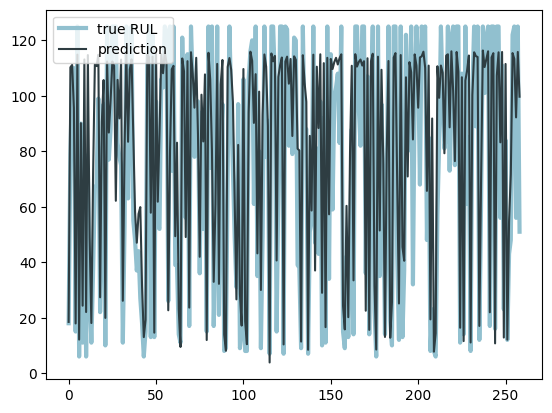

In [ ]:
mus, sigmas = get_predictions_ensemble(prediction_fns2, x_test, y_test, settings['model_name'], True)

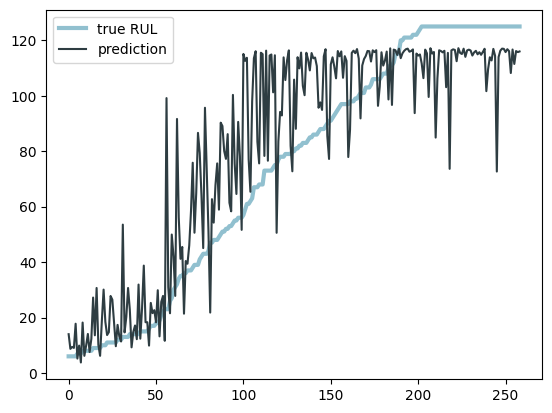

In [ ]:
plot_sorted(mus, y_test, settings['model_name'], True)

In [ ]:
import pickle
outputs_base = []

for p in prediction_fns2:
  outputs_base.append(p(x_test))

filehandler = open(b"/content/drive/MyDrive/pickled_predictions_new/DS2_clust1_outputs_var13ConvDropout.pkl","ab")
pickle.dump(outputs_base,filehandler)

# Dataset3

In [ ]:
dataset = 'FD003'
# files
dir_path = '/content/drive/MyDrive/CMAPSSData/'



# data readout
sensor_names  = ["tfan_in_tot", "tLPC_out_tot", "tHPC_out_tot",
           "tLPT_out_tot", "pfan_in", "pbypass_tot", "pHPC_out_tot", "fan_speed_physical", "core_speed_physical",
           "P50_P2_ratio", "pHPC_out_stat", "fuel_flow_to_Ps30", "fan_speed_corrected", "core_speed_corrected",
           "bypass_ratio", "burnerfuel_air_ratio", "bleed_enthalpy", "fan_speed_demanded", "fan_speed_demanded_corrected" ,
           "HPT_coolant_bleed", "LPT_coolant_bleed"]


sensors = ['tLPC_out_tot', 'tHPC_out_tot', 'tLPT_out_tot', 'pbypass_tot',
       'pHPC_out_tot', 'fan_speed_physical', 'core_speed_physical',
       'pHPC_out_stat', 'fuel_flow_to_Ps30', 'fan_speed_corrected',
       'core_speed_corrected', 'bypass_ratio', 'bleed_enthalpy',
       'HPT_coolant_bleed', 'LPT_coolant_bleed']




In [ ]:
disable_eager_execution()




x_train, y_train, x_val, y_val, x_test, y_test, X_train_pre, X_test_pre = process_data_standard(dataset, sensors, dir_path, 'regr')
settings = {'model_name': 'DS3_LSTM_var12ConvDropout', 'window_length' : 30, 'batch_size' : 256, 'lstm1' : 64, 'lstm2' : 32, 'lstm3': 16, 'dropout':0.2, 'convolution':32,
            'shape_1' :  32, 'gaussiann_layer': 1, 'sensors':sensors, 'monitor':'val_loss'}

tf.keras.utils.set_random_seed(237)
start_time = time.time()
prediction_fns2 = []
for i in range(10):
    prediction_fns2.append(create_trained_network_conv2(x_train, y_train, i))

end_time = time.time()
run_time = end_time - start_time
settings['time'] = run_time


RMSE with clipped RUL is 15.459095990661275
RMSE with clipped RUL is 16.891456580285055


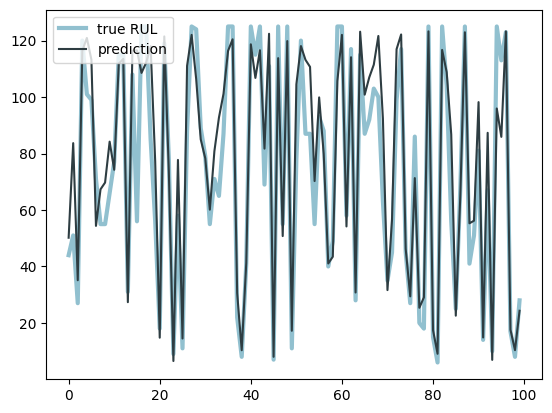

In [ ]:
mus, sigmas = get_predictions_ensemble(prediction_fns2, x_test, y_test, settings['model_name'], True)

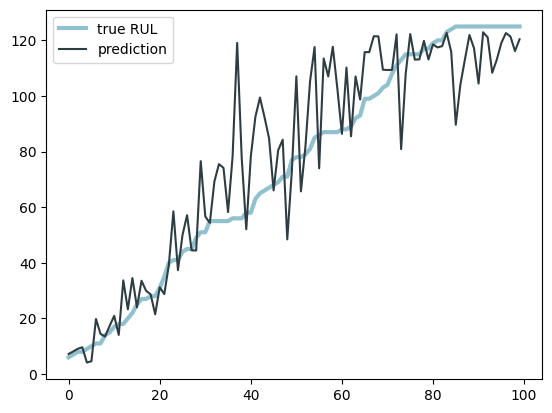

In [ ]:
plot_sorted(mus, y_test, settings['model_name'], True)

In [ ]:
import pickle
outputs_base = []

for p in prediction_fns2:
  outputs_base.append(p(x_test))

filehandler = open(b"/content/drive/MyDrive/pickled_predictions_new/DS3_outputs_var13ConvDropout.pkl","ab")
pickle.dump(outputs_base,filehandler)

# Dataset 4

In [ ]:
dataset = 'FD004'
# files
dir_path = '/content/drive/MyDrive/CMAPSSData/'



# data readout
sensor_names  = ["tfan_in_tot", "tLPC_out_tot", "tHPC_out_tot",
           "tLPT_out_tot", "pfan_in", "pbypass_tot", "pHPC_out_tot", "fan_speed_physical", "core_speed_physical",
           "P50_P2_ratio", "pHPC_out_stat", "fuel_flow_to_Ps30", "fan_speed_corrected", "core_speed_corrected",
           "bypass_ratio", "burnerfuel_air_ratio", "bleed_enthalpy", "fan_speed_demanded", "fan_speed_demanded_corrected" ,
           "HPT_coolant_bleed", "LPT_coolant_bleed"]


sensors = ['tLPC_out_tot', 'tHPC_out_tot', 'tLPT_out_tot', 'pbypass_tot',
       'pHPC_out_tot', 'fan_speed_physical', 'core_speed_physical',
       'pHPC_out_stat', 'fuel_flow_to_Ps30', 'fan_speed_corrected',
       'core_speed_corrected', 'bypass_ratio', 'bleed_enthalpy',
       'HPT_coolant_bleed', 'LPT_coolant_bleed']




In [ ]:
disable_eager_execution()




x_train, y_train, x_val, y_val, x_test, y_test, X_train_pre, X_test_pre = process_data_standard(dataset, sensors, dir_path, 'regr')
settings = {'model_name': 'DS4_LSTM_var12ConvDropout', 'window_length' : 30, 'batch_size' : 256, 'lstm1' : 64, 'lstm2' : 32, 'lstm3': 16, 'dropout':0.2, 'convolution':32,
            'shape_1' :  32, 'gaussiann_layer': 1, 'sensors':sensors, 'monitor':'val_loss'}

tf.keras.utils.set_random_seed(237)
start_time = time.time()
prediction_fns2 = []
for i in range(10):
    prediction_fns2.append(create_trained_network_conv2(x_train, y_train, i))

end_time = time.time()
run_time = end_time - start_time
settings['time'] = run_time


RMSE with clipped RUL is 28.94398172858728
RMSE with clipped RUL is 47.4821590312216


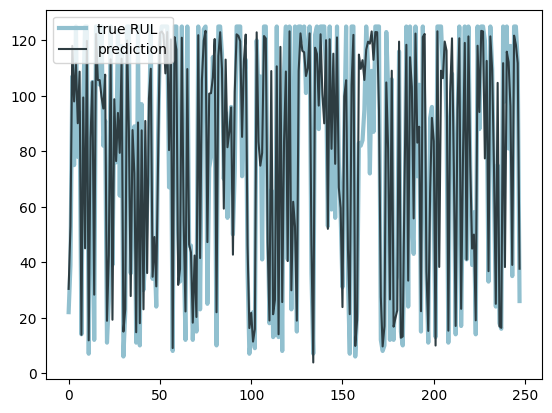

In [ ]:
mus, sigmas = get_predictions_ensemble(prediction_fns2, x_test, y_test, settings['model_name'], True)

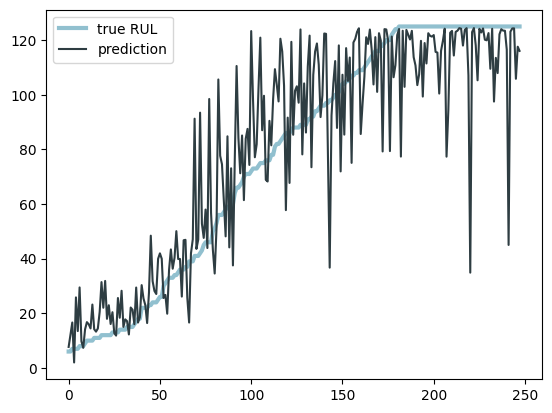

In [ ]:
plot_sorted(mus, y_test, settings['model_name'], True)

In [ ]:
import pickle
outputs_base = []

for p in prediction_fns2:
  outputs_base.append(p(x_test))

filehandler = open(b"/content/drive/MyDrive/pickled_predictions_new/DS4_outputs_var13ConvDropout.pkl","ab")
pickle.dump(outputs_base,filehandler)